#### Notebook config

In [1]:
# %load ~/software/fullwavepy/fullwavepy/config/jupyter.py
from fullwavepy import * # Load modules imported in fullwavepy/__init__.py
# -----------------------------------------------------------------------------
# Set aliases of frequently used jupyter magic commands
# -----------------------------------------------------------------------------
%alias_magic mi matplotlib -p inline
%alias_magic mn matplotlib -p notebook
# -----------------------------------------------------------------------------
# Set matplotlib backend
# -----------------------------------------------------------------------------
# non-interactive plots displayed in a notebook cell
%matplotlib inline
# interactive plots displayed in a notebook cell
# %matplotlib notebook (interactive version)
# -----------------------------------------------------------------------------
# Set matplotlib style
# ----------------------------------------------------------------------------
plt.style.reload_library()
# a combined style (right overwrites left wherever they overlap):
plt.style.use(['default', 'ggplot'])
# print(plt.style.available) 
# -----------------------------------------------------------------------------
# Configure logging
# -----------------------------------------------------------------------------
# Set up loggers, handlers and load the log_lvl function
from fullwavepy.config.logging import *
# -----------------------------------------------------------------------------
# Set level of log-messages
log_lvl(ERROR) 
# Other options in order of increasing importance and 
# decreasing verbosity:
# TRACE, DEBUG, INFO, WARNING, ERROR, CRITICAL
# or using integers: 0, 10, 20, 30, 40, 50, respectively
# -----------------------------------------------------------------------------
# Autocompleting
# -----------------------------------------------------------------------------
#  Not sure if it works
#%config IPCompleter.greedy=True 
# -----------------------------------------------------------------------------
# Automatically reload modules before execution
#%load_ext autoreload
#%autoreload 2

Created `%mi` as an alias for `%matplotlib inline`.
Created `%mn` as an alias for `%matplotlib notebook`.


In [2]:
path_eph = '/home/kmc3817/rds_home/my_ephemeral/PROJECTS/ch_mel/'
path_fig = '/home/kmc3817/a_projects_dd1/01_thesis/figures/ch_mel/'

In [3]:
path = '/home/kmc3817/c_projects_phd/fwi_sant_kolumbo/'
geom = {'box': [8000.0, 25000.0, -3000.0, 15000.0, 0, 4000.0],
 'dt': 0.0025,
 'dx': 50,
 'ns': 2000}
p14 = ProjInv('p14', path=path, cat=0, **geom)

In [4]:
# Load PROTEUS metadata 
from fullwavepy.seismic.proteus import PROTEUS
from fullwavepy.ioapi.proteus import ProteusExperiment
lll(40)
xp = PROTEUS()
pro = ProteusExperiment()
lll(20)

##### Optional

In [ ]:
# %load fwipy_config.py 

In [51]:
# Import light-weight FWI framework 
# from fwilight.fwi import *
# from fwilight.ndat import *

### Code to package

In [5]:
def vp_KG(K, G, rho):
    return np.sqrt((K + 4./3*G) / rho)
def vs_KG(K, G, rho):
    return np.sqrt(G / rho)
def K_from_vels(vp, vs, rho):
    return rho*(vp**2 - 4/3*vs**2)
def G_from_vels(vs, rho):
    return rho * vs**2
def calc_bounds(ro1, K1, G1, ro2, K2, G2):
    from elasticc.limits import Reuss, Voigt, hs_bounds
    c2 = np.linspace(0,1,1000) # fluid fraction
    c1 = 1 - c2                # solid fraction
    Kr = Reuss(K1,c1,K2,c2)
    Gr = Reuss(G1,c1,G2,c2)
    Kv = Voigt(K1,c1,K2,c2)
    Gv = Voigt(G1,c1,G2,c2)
    Khs1, Ghs1 = hs_bounds(K1,K2,G1,G2,c1,c2)
    Khs2, Ghs2 = hs_bounds(K2,K1,G2,G1,c2,c1)
    K = dict(name='Bulk', v=Kv, r=Kr, hs1=Khs1, hs2=Khs2)
    G = dict(name='Shear', v=Gv, r=Gr, hs1=Ghs1, hs2=Ghs2)
    return c1, c2, K, G
def plot_bounds(ro1, K1, G1, ro2, K2, G2):
    c1, c2, K, G = calc_bounds(ro1, K1, G1, ro2, K2, G2)
    
    for i, M in enumerate([K,G]): 
        plt.subplot(121+i)
        plt.plot(c2,M['hs1'], label='H-S 1')
        plt.plot(c2,M['hs2'],label='H-S 2')
        plt.fill_between(c2, M['hs1'], M['hs2'], color='w')
#         for bound in ['v', 'r']
#         plt.plot(c2,Kv,'k--', label='Voigt')
#         plt.plot(c2,Gv, label='Goigt')
#         plt.plot(c2,Kr,'g--', label='Reuss')
#         plt.plot(c2,(M['r']+M['v'])/2, label='VRS', c='k') # Voigt-Reuss-Hill average
        plt.xlabel('Melt fraction')
        plt.ylabel('%s modulus (GPa)' % M['name'])
        plt.xlim(0,1)
        plt.ylim(0,100)
        plt.grid()
        _ = plt.legend()     

# P-wave velocity anomaly

Extracting anomolies (subtracting some reference model from the recovered one) serves visualisation purposes only. What is fed into the homogenisation (see below) is the absolute value of the recovered model.

#### Tab.
Vp of the final and reference model at the depth of the maximum anomaly.

In [18]:
x1

8000.0

In [24]:
x, y, z = 13.2e3, 8.9e3, 2.55e3 # see 0843_Recovered_model
h = 50 # m
x1, x2, y1, y2, z1, z2 = p14.box
i, j, k = (x-x1)/h, (y-y1)/h, (z-z1)/h
i, j, k = [int(i) for i in [i,j,k]]

In [25]:
vp_final = Arr3d(p14.o.vp.it[160].read())
vp_final[i,j,k]

3399.6052

In [13]:
vp_final = A3d(p14.o.vp.it[80].read())
vp_final[105,235,55]

3788.9902

In [10]:
vp1d[55]

5344.311

## P-wave velocity anomaly 1
Reference -- metamorphic block.

#### Fig.
The reference domain consisting mainly of a metamorphic block.

CPU times: user 72 ms, sys: 44 ms, total: 116 ms
Wall time: 114 ms


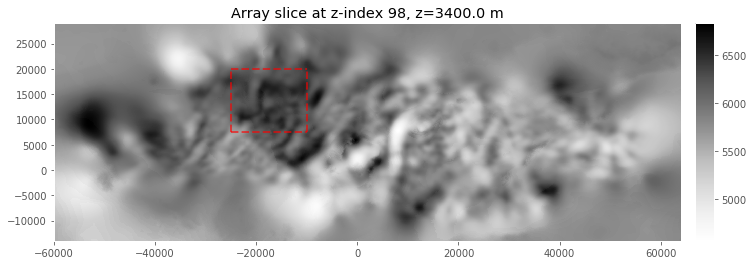

In [6]:
%%time
bh = A3d(pro.svp['bh']['18-04-24'])
figure(14,4)
bh.plot(3.4e3, unit='m', axis='z', overwrite=0, overwrite_mmp=0, aspect='equal', cmap='Greys')
# b = Box(-2.5e4,-1e4,7.5e3,2e4,-1.5e3,5e3)
b = Box(-2.5e4,-1e4,7.5e3,2e4,0,4e3) # same depth range as Kolumbo results!
b.plot_zslice()

#### Alg.
Carve out the block.

In [7]:
vp = A3d(bh.carve(b.box))

#### Fig.
Reference domain zoomed in.

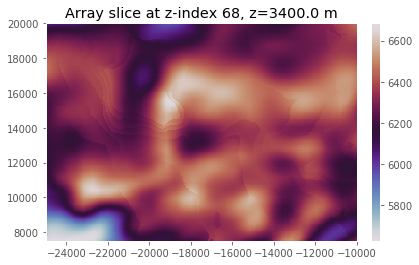

In [29]:
vp.plot(3.4e3, unit='m', axis='z', cmap='twilight')

#### Alg.
Take the average 1d profile.

In [8]:
vp1d = np.mean(vp, axis=(0,1))
vp.shape, vp1d.shape

((301, 251, 81), (81,))

#### Fig.
Reference 1d profile.

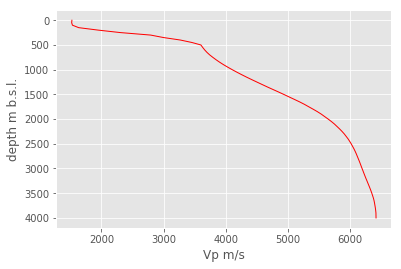

In [31]:
# code 
z = np.arange(vp.extent[-1][0], vp.extent[-1][1]+1, vp.dx[-1])
fig, ax = figax(6,4)
ax.plot(vp1d, z, c='r')
ax.invert_yaxis()
ax.grid()
ax.set_xlabel('Vp m/s')
_ = ax.set_ylabel('depth m b.s.l.')

#### Alg.
Subtract the 1d model from the starting model (full domain).

In [32]:
dbh = A3d(bh - vp1d, extent=bh.extent)

ValueError: operands could not be broadcast together with shapes (2481,861,131) (81,) 

#### Fig.
Residual for the starting model.

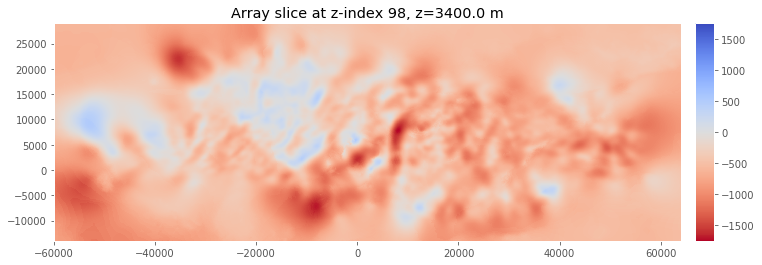

In [24]:
figure(14,4)
dbh.plot(3.4e3, unit='m', axis='z', center_cmap=1, cmap='coolwarm_r', aspect='equal')

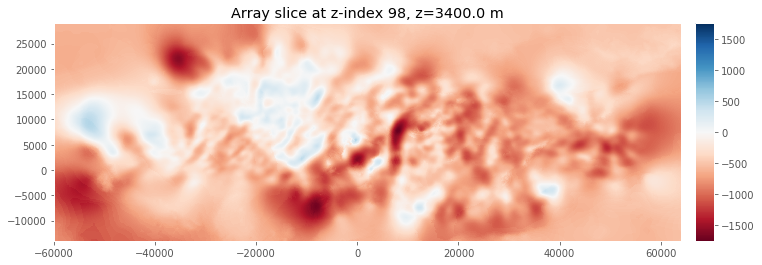

In [22]:
figure(14,4)
dbh.plot(3.4e3, unit='m', axis='z', center_cmap=1, cmap='RdBu', aspect='equal')

#### Alg.
Subtract the 1d model from the final model (`p14`, it. 80).

In [9]:
# code 
dt = 0.0025  
ns = 2000    
dx = 50      
x1 = +8.0e3     
x2 = +2.5e4    
y1 = -3.0e3    
y2 = +1.5e4    
z1 = 0 # CUT AT THE SEA SURFACE
z2 = 4000    
box = [x1, x2, y1, y2, z1, z2]
bigger_box = box
geom_bigger = dict(dt=dt, ns=ns, dx=dx, box=box)
path = '/home/kmc3817/c_projects_phd/fwi_sant_kolumbo/'
p14 = ProjInv('p14', path=path, **geom_bigger) # Lasso selected and good extra nodes but only ~80 it.
vp_final = A3d(p14.o.vp.it[80].read())
dvp_final = A3d(vp_final - vp1d, extent=vp_final.extent)

Content of  /home/kmc3817/c_projects_phd/fwi_sant_kolumbo//p14/p14-Info.txt : 
 cat: /home/kmc3817/c_projects_phd/fwi_sant_kolumbo//p14/p14-Info.txt: No such file or directory

INFO:fullwavepy.project.generic.au.ProjDef.__init__: 
-----------------------------------------
Project definition
-----------------------------------------
problem             :          tomography
domain              :                time
dim                 :                  3d
equation            :            acoustic
anisotropy          :                none
kernel              :                 low
io                  :                 sgy
units               :              metric
qp                  :                   0
qs                  :                   0
INFO:fullwavepy.project.generic.au.ProjSgyMapp.__init__: Setting SEG-Y mapping (sgyhw) to Fullwave3D's default.
INFO:fullwavepy.project.generic.au.ProjCluster.__init__: Setting cluster to default - cx1.
INFO:fullwavepy.project.files.text.runfiles

INFO:fullwavepy.project.files.text.misc.LastCheckpointFile.__init__: Last checkpoint: 0
INFO:fullwavepy.project.lists.basic.ShotFileList._read_sids: SLAVES_DUMPCSREFS not defined. Assuming dumps for all sids


INFO:fullwavepy.project.lists.basic.ShotFileList._read_sids: SLAVES_DUMPCSREFS not defined. Assuming dumps for all sids


INFO:fullwavepy.project.lists.basic.ShotFileList._read_sids: SLAVES_DUMPCSREFS not defined. Assuming dumps for all sids


INFO:fullwavepy.ioapi.generic.read_any: If the array looks corrupted try overwrite_mmp=True.


#### Fig.
Residual for the final model.

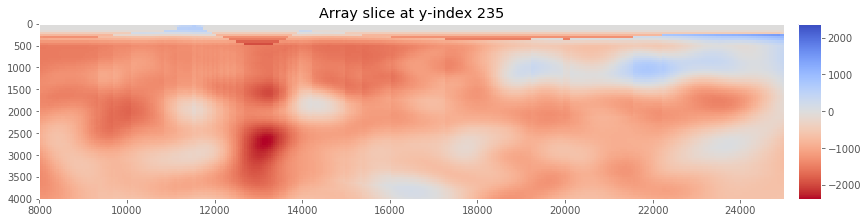

In [54]:
figure(14,4)
dvp_final.plot(235, unit='n', axis='y', center_cmap=1, cmap='coolwarm_r', aspect='equal')

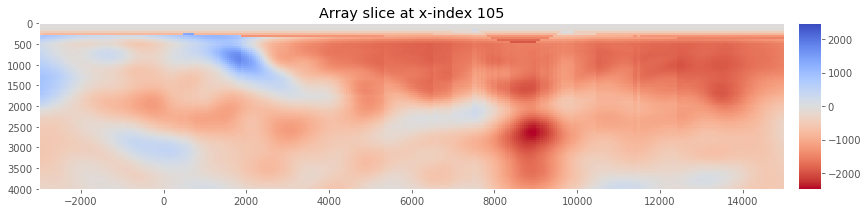

In [55]:
figure(14,4)
dvp_final.plot(105, unit='n', axis='x', center_cmap=1, cmap='coolwarm_r', aspect='equal')

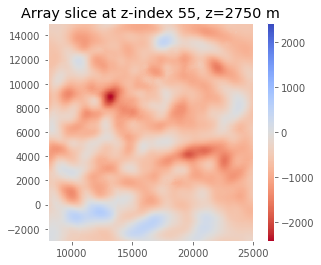

In [56]:
figure(14,4)
dvp_final.plot(2750, unit='m', axis='z', center_cmap=1, cmap='coolwarm_r', aspect='equal')

#### Tab.
Maximum velocity reduction (relative to the reference model) is approx. 2.5 km/s! No T or p corrections were applied though.

In [12]:
np.min(dvp_final)

A3d(-2480.2625, dtype=float32)

#### Alg.
Subtract the 1d model from the final model (`p12`, it. 160).

In [ ]:
# code 
dt = 0.0025  
ns = 2000    
dx = 50      
x1 = +8.0e3     
x2 = +2.5e4    
y1 = -3.0e3    
y2 = +1.5e4    
z1 = 0 # CUT AT THE SEA SURFACE
z2 = 4000    
box = [x1, x2, y1, y2, z1, z2]
bigger_box = box
geom_bigger = dict(dt=dt, ns=ns, dx=dx, box=box)
path = '/home/kmc3817/c_projects_phd/fwi_sant_kolumbo/'
p12 = ProjInv('p12', path=path, **geom_bigger) # too few extra nodes => abs. bnd. within the model
p14 = ProjInv('p14', path=path, **geom_bigger) # Lasso selected and good extra nodes but only ~80 it.
vp14 = A3d(p12.o.vp.it[160].read())

## P-wave velocity anomaly 2
Reference -- average Kolumbo.

#### Fig.
The reference domain -- the Kolumbo box. In this way no temperature and pressure corrections are needed. Especially assumptions about background geotherm.

CPU times: user 132 ms, sys: 136 ms, total: 268 ms
Wall time: 267 ms


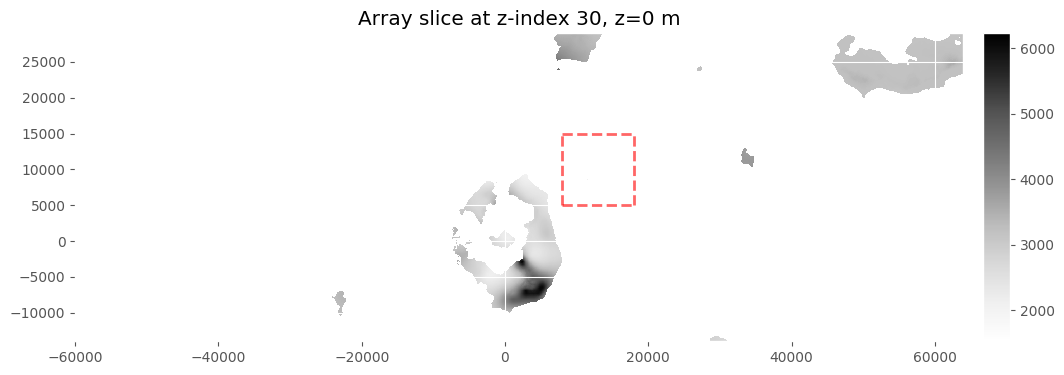

In [53]:
%%time
bh = A3d(pro.svp['bh']['18-04-24'])
figure(14,4)
bh.plot(0, unit='m', axis='z', overwrite=0, overwrite_mmp=0, aspect='equal')
# x1 = +1.0e4     
# x2 = +1.6e4    
# y1 = +6.0e3    
# y2 = +1.2e4  
x1 = +0.8e4     
x2 = +1.8e4    
y1 = +0.5e4    
y2 = +1.5e4  
z1 = 0 # CUT AT THE SEA SURFACE
z2 = +4.0e3 
b = Box(x1,x2,y1,y2,z1,z2) 
b.plot_zslice()

vp = A3d(bh.carve(b.box))

CPU times: user 100 ms, sys: 100 ms, total: 200 ms
Wall time: 200 ms


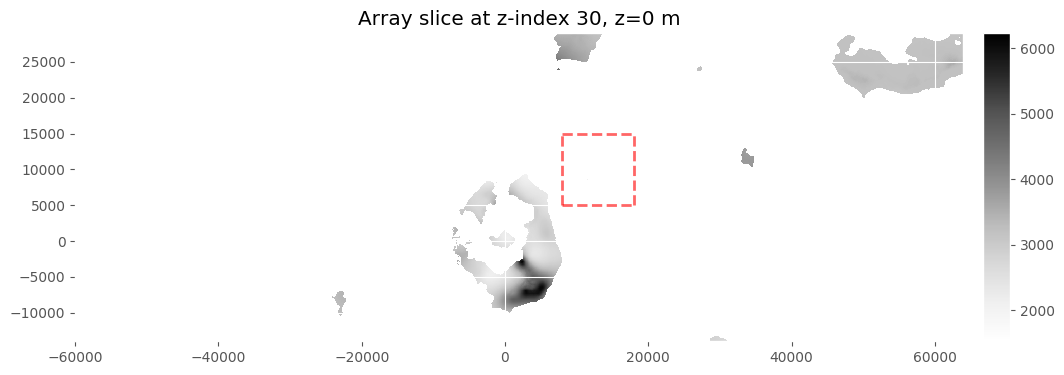

In [54]:
%%time
bh = A3d(pro.svp['bh']['18-04-24'])
figure(14,4)
bh.plot(0, unit='m', axis='z', overwrite=0, overwrite_mmp=0, aspect='equal')
# x1 = +1.0e4     
# x2 = +1.6e4    
# y1 = +6.0e3    
# y2 = +1.2e4  
x1 = +0.8e4     
x2 = +1.8e4    
y1 = +0.5e4    
y2 = +1.5e4  
z1 = 0 # CUT AT THE SEA SURFACE
z2 = +4.0e3 
b = Box(x1,x2,y1,y2,z1,z2) 
b.plot_zslice()

vp = A3d(bh.carve(b.box))

#### Fig.
The reference domain zoomed in.

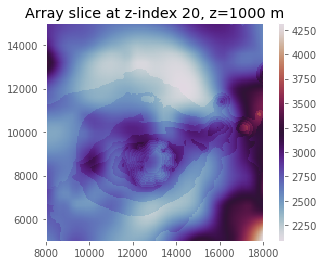

In [40]:
# code 
_ = vp.plot(1000, unit='m', axis='z', cmap='twilight', noextent=0, aspect='equal')

#### Fig.
Reference 1d profile.

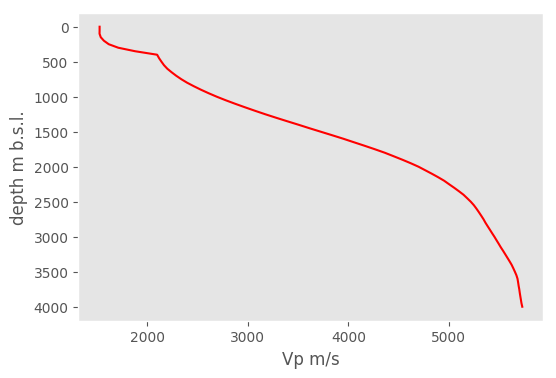

In [55]:
# code 
vp1d = np.mean(vp, axis=(0,1))
# plot 
z = np.arange(vp.extent[-1][0], vp.extent[-1][1]+1, vp.dx[-1])
fig, ax = figax(6,4)
ax.plot(vp1d, z, c='r')
ax.invert_yaxis()
ax.grid()
ax.set_xlabel('Vp m/s')
_ = ax.set_ylabel('depth m b.s.l.')

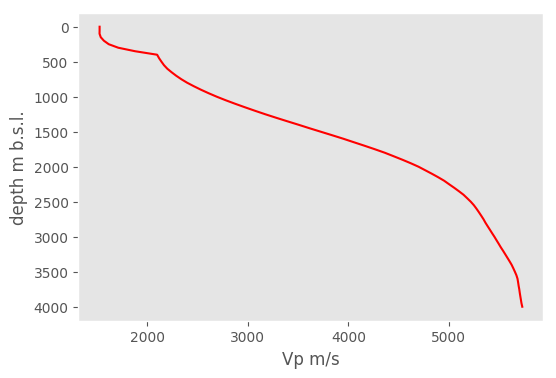

In [56]:
# code 
vp1d = np.mean(vp, axis=(0,1))
# plot 
z = np.arange(vp.extent[-1][0], vp.extent[-1][1]+1, vp.dx[-1])
fig, ax = figax(6,4)
ax.plot(vp1d, z, c='r')
ax.invert_yaxis()
ax.grid()
ax.set_xlabel('Vp m/s')
_ = ax.set_ylabel('depth m b.s.l.')

#### Alg.
Load the projects.

In [57]:
# code 
dt = 0.0025  
ns = 2000    
dx = 50      
x1 = +8.0e3     
x2 = +2.5e4    
y1 = -3.0e3    
y2 = +1.5e4    
z1 = 0 # CUT AT THE SEA SURFACE
z2 = 4000    
box = [x1, x2, y1, y2, z1, z2]
bigger_box = box
geom_bigger = dict(dt=dt, ns=ns, dx=dx, box=box)
path = '/home/kmc3817/c_projects_phd/fwi_sant_kolumbo/'
lll(40)
p12 = ProjInv('p12', path=path, **geom_bigger, cat=0)
p14 = ProjInv('p14', path=path, **geom_bigger, cat=0) # Lasso selected and good extra nodes but only ~80 it.

#### Alg.
Save mmp for binder.

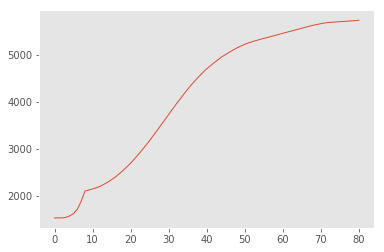

In [90]:
from fullwavepy.ioapi.memmap import *
fname = 'ref1d_kol01_shape1x1x81.mmp'
shape = (1,1,len(vp1d))
a = np.zeros(shape)
a[0,0] = vp1d
save_mmp(a, fname)
b = read_mmp(fname, shape)
plt.plot(b[0,0])

#### Fig.
Residual for the final models of `p12` which has more artifacts than `p14` due to wrong boundaries.

-1396.8916
-1621.1887
-1750.4639
-1992.8494


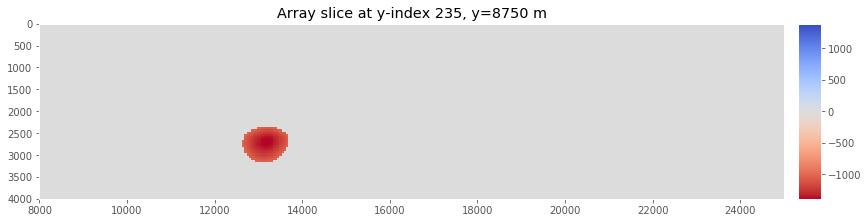

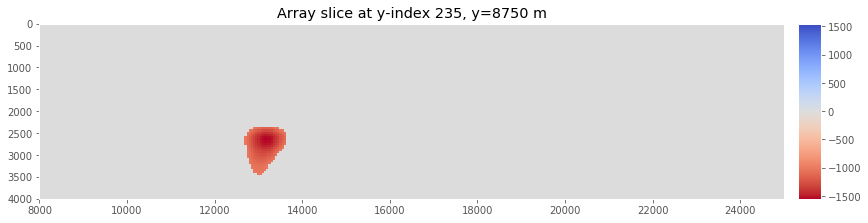

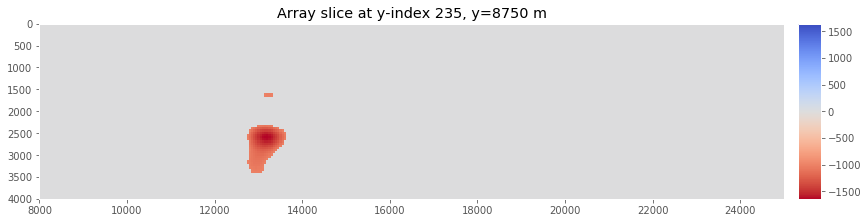

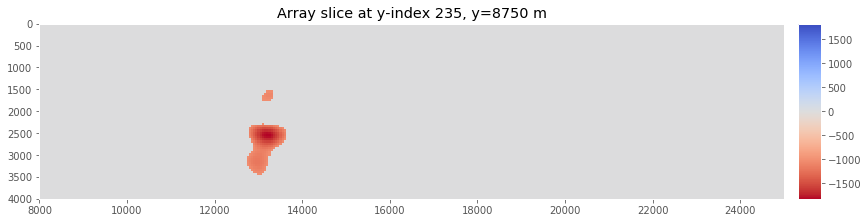

In [76]:
for it in range(40,170,40):
    figure(14,4)
    vp_final = A3d(p12.o.vp.it[it].read())
    dvp_final = A3d(vp_final - vp1d, extent=vp_final.extent)
    print(np.min(dvp_final))
    dvp_final[dvp_final > -1e3] = 0
    dvp_final.plot(8750, unit='m', axis='y', center_cmap=1, cmap='coolwarm_r', aspect='equal', clip=2e3)

#### Fig.
Residual for the final models of `p14`.

-1487.2192
-1695.3381


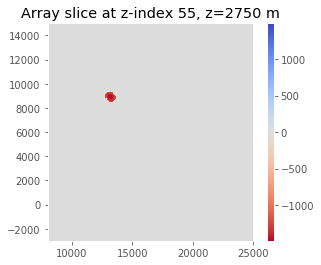

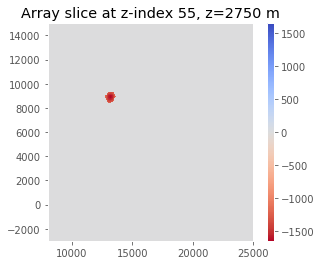

In [74]:
for it in range(40,90,40):
    figure(14,4)
    vp_final = A3d(p14.o.vp.it[it].read())
    dvp_final = A3d(vp_final - vp1d, extent=vp_final.extent)
    print(np.min(dvp_final))
#     dvp_final[np.abs(dvp_final) < 1e3] = 0
    dvp_final[dvp_final > -1.2e3] = 0
#     dvp_final.plot(8750, unit='m', axis='y', center_cmap=1, cmap='coolwarm_r', aspect='equal', clip=2e3)
    dvp_final.plot(2750, unit='m', axis='z', center_cmap=1, cmap='coolwarm_r', aspect='equal', clip=2e3)

#### Fig.
Various slices of the residual for the final models of `p14`.

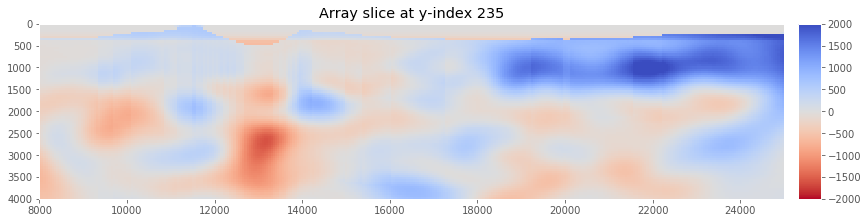

In [20]:
figure(14,4)
dvp_final.plot(235, unit='n', axis='y', center_cmap=1, cmap='coolwarm_r', aspect='equal', clip=2e3)

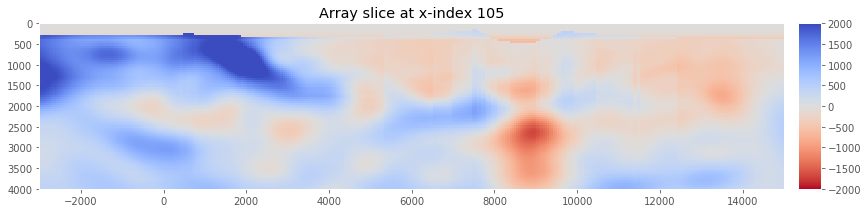

In [19]:
figure(14,4)
dvp_final.plot(105, unit='n', axis='x', center_cmap=1, cmap='coolwarm_r', aspect='equal', clip=2e3)

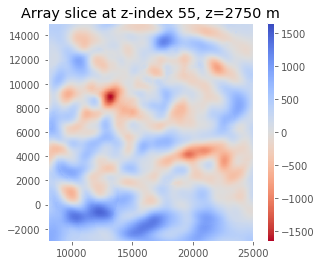

In [21]:
figure(14,4)
dvp_final.plot(2750, unit='m', axis='z', center_cmap=1, cmap='coolwarm_r', aspect='equal', clip=2e3)

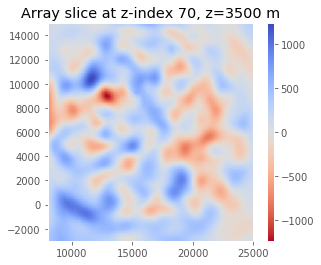

In [24]:
figure(14,4)
dvp_final.plot(3500, unit='m', axis='z', center_cmap=1, cmap='coolwarm_r', aspect='equal', clip=2e3)

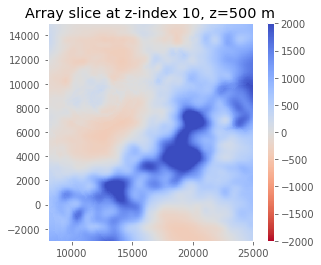

In [23]:
figure(14,4)
dvp_final.plot(500, unit='m', axis='z', center_cmap=1, cmap='coolwarm_r', aspect='equal', clip=2e3)

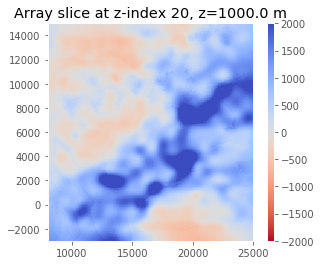

In [22]:
figure(14,4)
dvp_final.plot(1e3, unit='m', axis='z', center_cmap=1, cmap='coolwarm_r', aspect='equal', clip=2e3)

#### Alg.
Variable opacity mask.

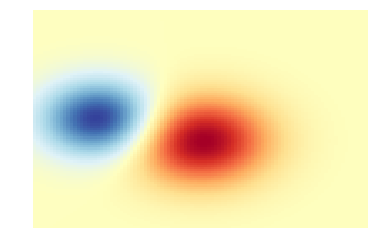

In [75]:
# code 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


def normal_pdf(x, mean, var):
    return np.exp(-(x - mean)**2 / (2*var))


# Generate the space in which the blobs will live
xmin, xmax, ymin, ymax = (0, 100, 0, 100)
n_bins = 100
xx = np.linspace(xmin, xmax, n_bins)
yy = np.linspace(ymin, ymax, n_bins)

# Generate the blobs. The range of the values is roughly -.0002 to .0002
means_high = [20, 50]
means_low = [50, 60]
var = [150, 200]

gauss_x_high = normal_pdf(xx, means_high[0], var[0])
gauss_y_high = normal_pdf(yy, means_high[1], var[0])

gauss_x_low = normal_pdf(xx, means_low[0], var[1])
gauss_y_low = normal_pdf(yy, means_low[1], var[1])

weights = (np.outer(gauss_y_high, gauss_x_high)
           - np.outer(gauss_y_low, gauss_x_low))

# We'll also create a grey background into which the pixels will fade
greys = np.full((*weights.shape, 3), 70, dtype=np.uint8)

# First we'll plot these blobs using ``imshow`` without transparency.
vmax = np.abs(weights).max()
imshow_kwargs = {
    'vmax': vmax,
    'vmin': -vmax,
    'cmap': 'RdYlBu',
    'extent': (xmin, xmax, ymin, ymax),
}

fig, ax = plt.subplots()
ax.imshow(greys)
ax.imshow(weights, **imshow_kwargs)
ax.set_axis_off()

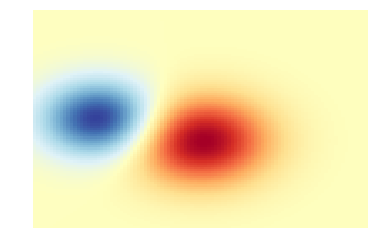

In [75]:
# code 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


def normal_pdf(x, mean, var):
    return np.exp(-(x - mean)**2 / (2*var))


# Generate the space in which the blobs will live
xmin, xmax, ymin, ymax = (0, 100, 0, 100)
n_bins = 100
xx = np.linspace(xmin, xmax, n_bins)
yy = np.linspace(ymin, ymax, n_bins)

# Generate the blobs. The range of the values is roughly -.0002 to .0002
means_high = [20, 50]
means_low = [50, 60]
var = [150, 200]

gauss_x_high = normal_pdf(xx, means_high[0], var[0])
gauss_y_high = normal_pdf(yy, means_high[1], var[0])

gauss_x_low = normal_pdf(xx, means_low[0], var[1])
gauss_y_low = normal_pdf(yy, means_low[1], var[1])

weights = (np.outer(gauss_y_high, gauss_x_high)
           - np.outer(gauss_y_low, gauss_x_low))

# We'll also create a grey background into which the pixels will fade
greys = np.full((*weights.shape, 3), 70, dtype=np.uint8)

# First we'll plot these blobs using ``imshow`` without transparency.
vmax = np.abs(weights).max()
imshow_kwargs = {
    'vmax': vmax,
    'vmin': -vmax,
    'cmap': 'RdYlBu',
    'extent': (xmin, xmax, ymin, ymax),
}

fig, ax = plt.subplots()
ax.imshow(greys)
ax.imshow(weights, **imshow_kwargs)
ax.set_axis_off()

# Composition

From the supplement of Klaver et al. (2016).

sample	unit	location						major elements in wt. %											
		degr. N	min.	degr. W	min.	depth (mbsl)		SiO2	TiO2	Al2O3	FeO*	MnO	MgO	CaO	Na2O	K2O	BaO	P2O5	
NA007-058	1650 AD	36	31.546	25	28.535	220		73.53	0.09	13.56	1.35	0.10	0.30	0.86	5.80	4.36	0.055	0.011	
NA007-071**	1650 AD	36	30.868	25	28.958	182		74.27	0.10	13.97	1.56	0.11	0.29	0.91	4.29	4.43	0.056	0.016	
NA007-073	1650 AD	36	30.837	25	28.942	151		73.66	0.09	13.61	1.39	0.10	0.30	0.84	5.56	4.39	0.053	0.012	
NA007-075*	1650 AD	36	31.163	25	29.473	373		75.29	0.07	13.73	1.42	0.12	0.21	0.89	4.04	4.21	n.d.	0.020	
NA007-085*	1650 AD	36	31.983	25	29.165	254		74.41	0.07	13.73	1.37	0.11	0.20	0.80	4.99	4.28	n.d.	0.030	
NA007-090**	1650 AD	36	31.736	25	28.766	292		74.77	0.08	13.74	1.42	0.10	0.23	0.84	4.32	4.43	0.054	0.013	
NA014-019**	1650 AD	36	31.587	25	29.207	502		74.43	0.10	13.94	1.50	0.10	0.17	0.90	4.42	4.36	0.058	0.018

# Pressure correction

The calculation is done at the bottom of the section.

#### Fig.
The domain of the starting model from which the reference 1d profile will be extracted (as an horizontal average). Inset -- zoom in.

CPU times: user 92 ms, sys: 36 ms, total: 128 ms
Wall time: 128 ms


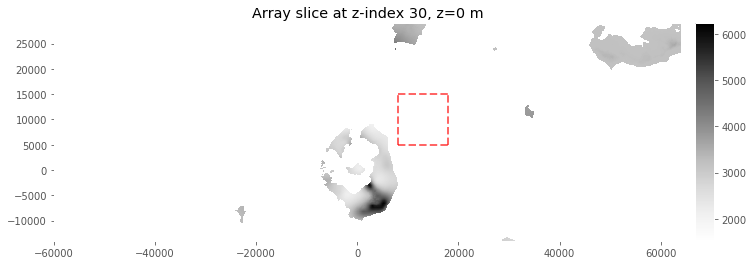

In [12]:
%%time
bh = A3d(pro.svp['bh']['18-04-24'])
figure(14,4)
bh.plot(0, unit='m', axis='z', overwrite=0, overwrite_mmp=0, aspect='equal')
x1 = +0.8e4     
x2 = +1.8e4    
y1 = +0.5e4    
y2 = +1.5e4  
z1 = 0 # CUT AT THE SEA SURFACE
z2 = +4.0e3 
b = Box(x1,x2,y1,y2,z1,z2) 
b.plot_zslice()
vp = A3d(bh.carve(b.box))

##### Inset

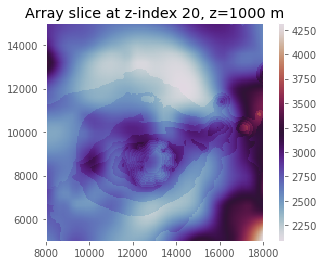

In [40]:
# code 
_ = vp.plot(1000, unit='m', axis='z', cmap='twilight', noextent=0, aspect='equal')

#### Fig.
Reference 1d profile of vp.

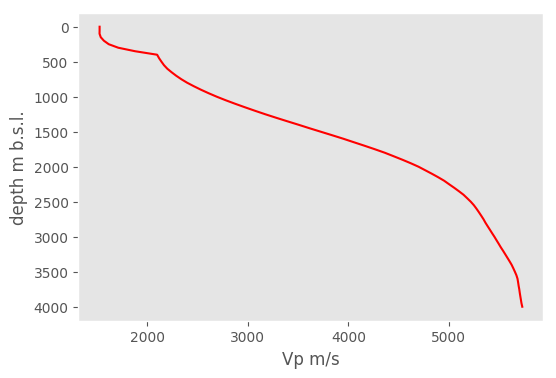

In [58]:
# code 
vp1d = np.mean(vp, axis=(0,1))
# plot 
z = np.arange(vp.extent[-1][0], vp.extent[-1][1]+1, vp.dx[-1])
fig, ax = figax(6,4)
ax.plot(vp1d, z, c='r')
ax.invert_yaxis()
ax.grid()
ax.set_xlabel('Vp m/s')
_ = ax.set_ylabel('depth m b.s.l.')

#### Fig.
Reference 1d profile of density calculated from vp.

In [49]:
def vp2dens_h2o(x):
    """
    Brocher's Vp to density relationship vp in m/s, density in g/cm^3
    Based on regression in Brocher (2005, doi:10.1785/0120050077)
    
    Parameters
    ----------
    x : float
      Vp in m/s
    
    Returns
    -------
    y : float
      Density in g/cm3
    
    Notes
    -----
    From https://github.com/michpaulatto/ElasticC.
    """    
    # Nafe-Drake from Brocher 2005
    y = lambda x: 1.6612*x - 0.4721*x**2 + 0.0671*x**3 - 0.0043*x**4 + 0.000106*x**5
    rho_h2o = 1 # g/cm3
    vp_rock_min = 1.6 # km/s
    return np.where(x<vp_rock_min, rho_h2o, y(x))

NameError: name 'vp2dens_h2o' is not defined

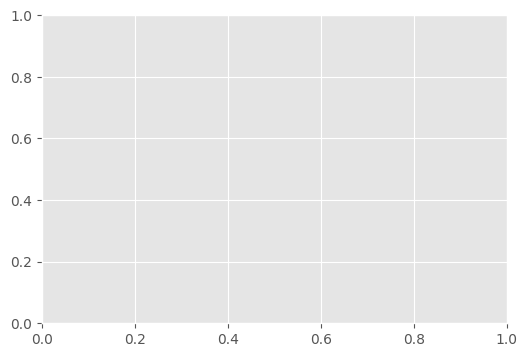

In [59]:
%%time 
fig, ax = figax(6,4)
rhos = vp2dens_h2o(vp1d/1000) # def of vp2dens below
ax.plot(rhos, z, c='r') 
ax.invert_yaxis()
ax.grid()
ax.set_xlabel('Density g/cm3')
_ = ax.set_ylabel('depth m b.s.l.')

#### Alg.
Lithostatic pressure calculation

In [99]:
def lith_press(rho1d, dz):
    """
    Lithostatic pressure calculation
    
    Parameters
    ----------
    rho1d : 1d array / list
      Depth profile of density for increasing depths.
      UNITS: g/cm3
    dz : float 
      Depth interval between elements of rho1d 
    Returns
    -------
    Lithostatic pressure in MPa.
    """
    rhos = rho1d * 1000 # conversion to kg/m3
    p0 = 0
    g = 10 # m/s2
    p = p0
    for rho in rhos:
        p = p + g * rho * dz
    p /= 10**6 # conversion to MPa
    return p

In [101]:
lith_press(rhos[:60], dz=50) # only upper 3 km

66.21002746582032

# Temperature correction

#### Alg. 
Karato's approach (not finished and thus **not** used, see the thesis).

In [20]:

# Various constants and variables
import math

# Constants
RR = 8.314472   # Gas constant J/mol

# Variables
FF = 1.0        # Dependence of Q on frequency
HH = 2.76e5     # Activation enthalpy J/mol
dvpdt0 = -5.7e-1
bbvp = -8.1e-5  # K-1 anharmonic dlnVp/Dt from Dunn 2000, Christensen 1979
const = FF*HH/math.pi/RR

# Parameters for dependence of Q on temperature
alpha = 0.15
f = 10.0
d = 500.


In [24]:

def t2vp_a(Vp,T0,DT,QQ):
# Estimate Vp anomaly from T anomaly using Karato (1993)
# Analytical solution
# Vp in km/s, T in kelvin
# Vp anomaly due to temperature change
        Vp1 = Vp*np.exp(bbvp*DT)*np.exp(const/QQ*(1/(T0+DT)-1/T0))
        return Vp1
t2vp_a(Vp=6.5, T0=273, DT=100, QQ=100)

5.812069244076796

In [26]:
def t2vp(Vp,T0,DT,Q):
    import math
    RR = 8.314472     # Gas constant J/mol
    FF = 1.0          # Dependence of Q on frequency
    HH = 2.76e5       # Activation enthalpy J/mol
    dvpdt0 = -5.7e-1
    anharm = -8.1e-5    # K-1 anharmonic dlnVp/Dt from Dunn 2000, Christensen 1979
    const = FF*HH/math.pi/RR
    
    dlogv = 0
    nsteps = 100
    dT = DT / nsteps
    for T in np.linspace(T0 + dT, T0 + DT, 100):
        dlogv += (anharm - const/Q/T**2) * dT
    Vpanot = Vp*np.exp(dlogv) - Vp
    return Vpanot


t2vp(Vp=6.5, T0=200, DT=100, Q=100)

-1.0895690176081212

In [29]:
a = 0
for i in range(2):
    a += i*4*2
    print(a)

0
8


# Analytical bounds

#### Fig.
Hashin-Shtrikman bounds on bulk $K$ and shear $\mu$ moduli calculated with `ElasticC` package using **example values** of elastic moduli.

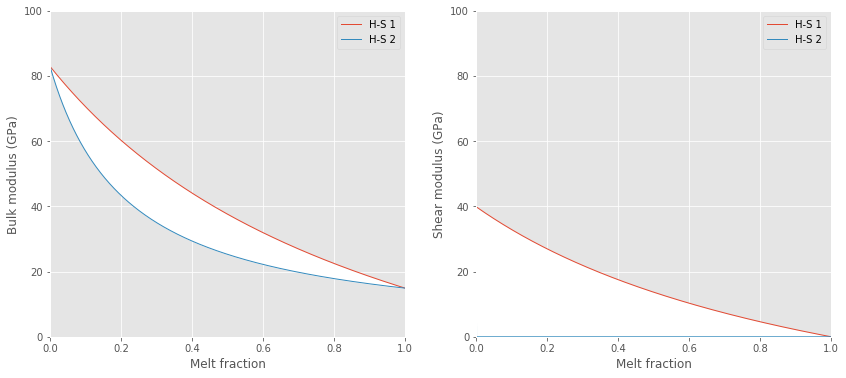

In [11]:
# code 
from elasticc.limits import *

# Solid phase properties
ro1 = 2.84     # kg/m3
K1 = 82.88333333333334 #(c11 + 2 * c12) / 3. 
G1 = 39.86 #c44 # mu

# Melt phase properties
ro2 = 2.7      # kg/m3
K2 = 1.491e1   # GPa
G2 = 1e-12     # GPa (numerical zero)

figure(14, )
plot_bounds(ro1, K1, G1, ro2, K2, G2)

#### Fig.
Same as above but for $v_P$ and $v_S$.

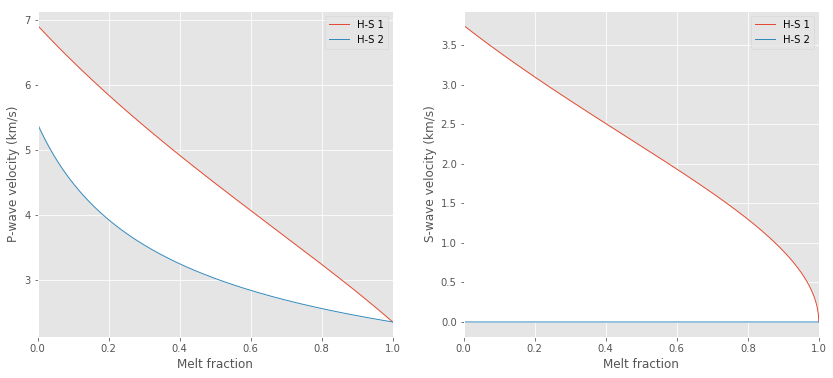

In [12]:
# code 
c1, c2, K, G = calc_bounds(ro1, K1, G1, ro2, K2, G2)
roe = Voigt(ro1,c1,ro2,c2)
figure(14,)
for i, (name, func) in enumerate(zip(['P-wave velocity', 'S-wave velocity'], [vp_KG, vs_KG])):
    a = func(K['hs1'], G['hs1'], roe)
    b = func(K['hs2'], G['hs2'], roe)
    plt.subplot(121+i)
    plt.plot(c2, a, label='H-S 1')
    plt.plot(c2, b, label='H-S 2')
    plt.fill_between(c2, a, b, color='w')
    plt.xlabel('Melt fraction')
    plt.ylabel('%s (km/s)' % name)
    plt.xlim(0,1)
    #         plt.ylim(0,100)
    plt.grid()
    _ = plt.legend()   

#### Tab.
Elastic moduli from McVey (2020) and Paulatto (2012).

In [60]:
# Solid phase properties (from McVey2020)
ro1 = 2.7    # g/cm3
K1 =  60     # GPa from Montserrat xlsx
G1 =  38     # GPa same

# Melt phase properties (from McVey2020)
# They need to be at the same (p,T) as solid matrix, I guess
ro2 = 2.65    # g/cm3
K2 = 12.35    # GPa
G2 = 1e-12    # GPa (numerical zero)

#### Fig.
Hashin-Shtrikman bounds on bulk $K$ and shear $\mu$ moduli calculated with `ElasticC` package using  values of elastic moduli from McVey (2020).

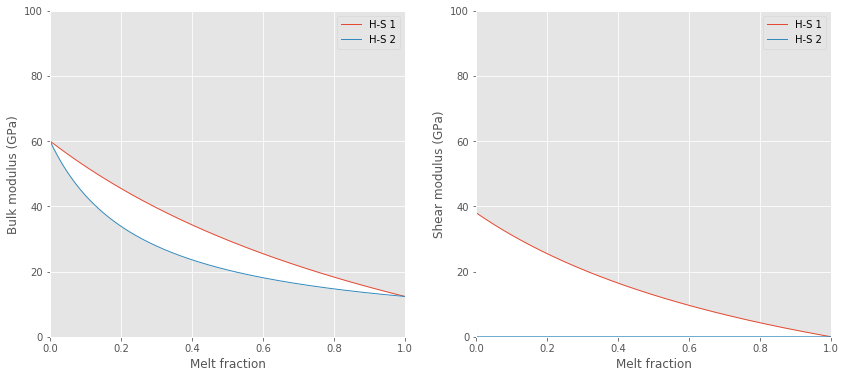

In [17]:
# code 
figure(14, )
plot_bounds(ro1, K1, G1, ro2, K2, G2)

#### Fig.
Same as above but for $v_P$ and $v_S$.

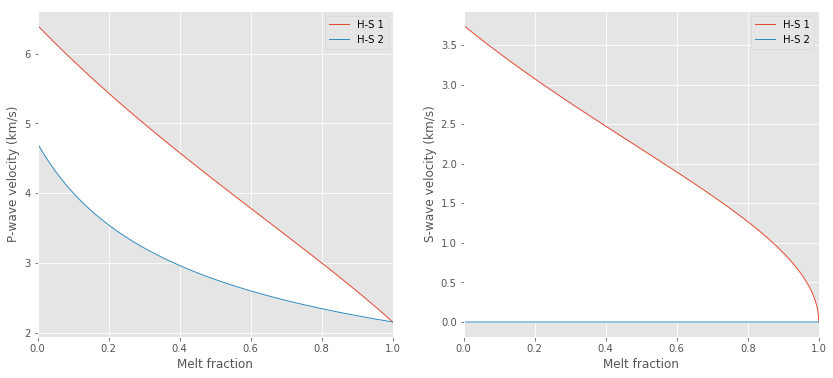

In [14]:
# code 
c1, c2, K, G = calc_bounds(ro1, K1, G1, ro2, K2, G2)
roe = Voigt(ro1,c1,ro2,c2)
figure(14,)
for i, (name, func) in enumerate(zip(['P-wave velocity', 'S-wave velocity'], [vp_KG, vs_KG])):
    a = func(K['hs1'], G['hs1'], roe)
    b = func(K['hs2'], G['hs2'], roe)
    plt.subplot(121+i)
    plt.plot(c2, a, label='H-S 1')
    plt.plot(c2, b, label='H-S 2')
    plt.fill_between(c2, a, b, color='w')
    plt.xlabel('Melt fraction')
    plt.ylabel('%s (km/s)' % name)
    plt.xlim(0,1)
    #         plt.ylim(0,100)
    plt.grid()
    _ = plt.legend()   

# SC homogenisation

#### Def.
Load the codes

In [80]:
from elasticc.eep import mod_b, gassman_2
from elasticc.limits import Voigt
from fullwavepy.plot.plt1d import colors

In [81]:
def calc(vp_ref=6.2, vpvs=1.73, ro1=2.7, ro2=2.65, 
         a1=1, a2=0.1, K2=12.35, G2=1e-12 ):
    """
    Parameters
    ---------
    vp_ref : float
        In km/s. IMPORTANT
    ro : float
        Density. In g/cm3
    a : float
        Aspect ratio.
    K : float
        Bulk modulus. In GPa.
    G : float
        Shear modulus. In GPa.
    """
    # solid
    vs_ref = vp_ref / vpvs
    K1 =  K_from_vels(vp_ref, vs_ref, ro1)  # GPa 
    G1 =  G_from_vels(vs_ref, ro1)          # GPa 
    # H-S bounds
    c1, c2, K_hs, G_hs = calc_bounds(ro1, K1, G1, ro2, K2, G2)
    roe = Voigt(ro1,c1,ro2,c2)
    vp_hs1 = vp_KG(K_hs['hs1'], G_hs['hs1'], roe)
    vp_hs2 = vp_KG(K_hs['hs2'], G_hs['hs2'], roe)
    # Relaxed, low frequency limit:
    # 1. Calculate dry moduli first (void fill)    
    a, b = vp_hs1, vp_hs2
    K_dry, G_dry = mod_b(K1,0.0,G1,0.0,a1,a2,c1,c2)
    # 2. Then use Gassman's fluid substitution
    K_lo, G_lo = gassman_2(K_dry,G_dry,K1,G1,K2,G2,c2) # NOTE
    vp_lo = vp_KG(K_lo, G_lo, roe)
    return a, b, c2, vp_lo

#### Fig.
Dependence on fluid pore aspect ratio.

In [91]:
%%time 
step = 0.05
vals = np.arange(0.05, .5+step, step)
hs1, hs2, vp = [], [], []
for i, a2 in enumerate(vals):
    a, b, c2, vp_lo = calc(a2=a2)
    hs1.append(a)
    hs2.append(b)
    vp.append(vp_lo)

CPU times: user 5.81 s, sys: 0 ns, total: 5.81 s
Wall time: 5.8 s


In [ ]:
# plot 
figure(9,8)
vp_fwi = 3.4 # km /s 
vp_err = 0.2 # km /s
title = 'Dependence on fluid pore aspect ratio'
cols = colors(len(vals),  cmap='rainbow') # 'rainbow'
for i, a2 in enumerate(vals):
    plt.fill_between(c2, hs1[i], hs2[i], color='w', alpha=.3)
    plt.plot(c2, vp[i], color=next(cols), label='%5.2f' % a2)
plt.fill_between(c2, np.ones(len(c2))*(vp_fwi-vp_err), np.ones(len(c2))*(vp_fwi+vp_err), 
                 color='k', alpha=.3)
plt.plot(c2, np.ones(len(c2))*(vp_fwi), 'k--')
plt.xlabel('Melt volume-fraction')
plt.ylabel('Observed P-wave velocity (km/s)')
plt.xlim(0,.7)
plt.ylim(2,6)
plt.grid(c='w')
plt.title(title)   
_ = plt.legend(prop={'size': 12}, ncol=2)     

#### Fig.
Dependence on fluid bulk modulus.

In [89]:
%%time 
vals = np.linspace(5, 20, 10)
hs1, hs2, vp = [], [], []
for i, K2 in enumerate(vals):
    a, b, c2, vp_lo = calc(K2=K2)
    hs1.append(a)
    hs2.append(b)
    vp.append(vp_lo)

CPU times: user 3.85 s, sys: 4 ms, total: 3.85 s
Wall time: 3.85 s


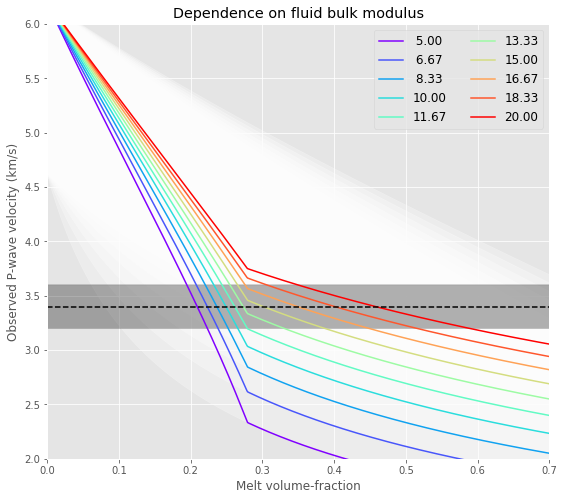

In [90]:
# plot 
figure(9,8)
vp_fwi = 3.4 # km /s 
vp_err = 0.2 # km /s
title = 'Dependence on fluid bulk modulus'
cols = colors(len(vals),  cmap='rainbow') # 'rainbow'
for i, K2 in enumerate(vals):
    plt.fill_between(c2, hs1[i], hs2[i], color='w', alpha=.3)
    plt.plot(c2, vp[i], color=next(cols), label='%5.2f' % K2)
plt.fill_between(c2, np.ones(len(c2))*(vp_fwi-vp_err), np.ones(len(c2))*(vp_fwi+vp_err), color='k', alpha=.3)
plt.plot(c2, np.ones(len(c2))*(vp_fwi), 'k--')
plt.xlabel('Melt volume-fraction')
plt.ylabel('Observed P-wave velocity (km/s)')
plt.xlim(0,.7)
plt.ylim(2,6)
plt.grid(c='w')
plt.title(title)   
_ = plt.legend(prop={'size': 12}, ncol=2)     

#### Fig.
Dependence on water content (to do).

## Less relevant

#### Fig.
Symmetric self-consistent approximation (Berryman 1980), high-frequency (unequilibriated) limit.

vp_ref 6.2
vp_fin 3788.9902
K1, G1 57.55057141902504 34.67807143573123


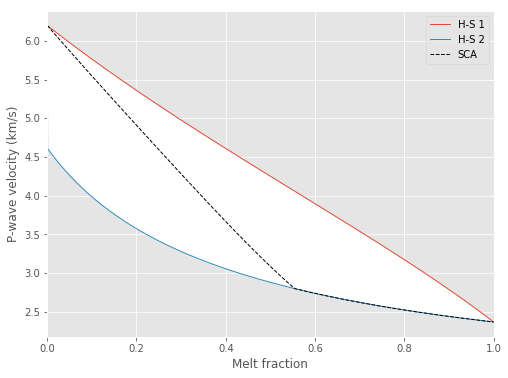

In [12]:
# code 
# vp_ref = vp1d[55] / 1000 # km/s

vp_ref = 6.2 
print('vp_ref', vp_ref)




vpvs = 1.73
vs_ref = vp_ref / vpvs
vp_final = A3d(p14.o.vp.it[80].read())
vp_fin = vp_final[105,235,55]
print('vp_fin', vp_fin)

ro1 = 2.7    # g/cm3
K1 =  K_from_vels(vp_ref, vs_ref, ro1)  # GPa 
G1 =  G_from_vels(vs_ref, ro1)          # GPa 
print('K1, G1', K1, G1)
# Melt phase properties (from McVey2020)
# They need to be at the same (p,T) as solid matrix, I guess


ro2 = 2.65    # g/cm3
# ro2 = 2.2

K2 = 12.35    # GPa
G2 = 1e-12    # GPa (numerical zero)

c1, c2, K, G = calc_bounds(ro1, K1, G1, ro2, K2, G2)
from elasticc.limits import Voigt
roe = Voigt(ro1,c1,ro2,c2)

from elasticc.eep import mod_b
a1 = 1    # aspect ratio of solid
a2 = 0.2  # aspect ratio of fluid
Ksc, Gsc = mod_b(K1,K2,G1,G2,a1,a2,c1,c2)
vsc = vp_KG(Ksc, Gsc, roe)

figure(8,)
for i, (name, func) in enumerate(zip(['P-wave velocity', 'S-wave velocity'], [vp_KG, vs_KG])):
    a = func(K['hs1'], G['hs1'], roe)
    b = func(K['hs2'], G['hs2'], roe)
#     plt.subplot(121+i)
    plt.plot(c2, a, label='H-S 1')
    plt.plot(c2, b, label='H-S 2')
    plt.fill_between(c2, a, b, color='w')
    if i == 0:
        plt.plot(c2, vsc, 'k--', label='SCA')
    plt.xlabel('Melt fraction')
    plt.ylabel('%s (km/s)' % name)
    plt.xlim(0,1)
    #         plt.ylim(0,100)
    plt.grid()
    _ = plt.legend()   
    break

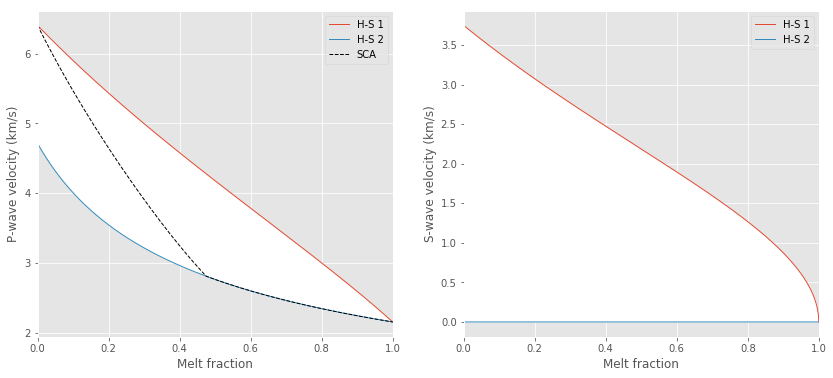

In [57]:
# plot 
c1, c2, K, G = calc_bounds(ro1, K1, G1, ro2, K2, G2)
roe = Voigt(ro1,c1,ro2,c2)
figure(14,)
for i, (name, func) in enumerate(zip(['P-wave velocity', 'S-wave velocity'], [vp_KG, vs_KG])):
    a = func(K['hs1'], G['hs1'], roe)
    b = func(K['hs2'], G['hs2'], roe)
    plt.subplot(121+i)
    plt.plot(c2, a, label='H-S 1')
    plt.plot(c2, b, label='H-S 2')
    plt.fill_between(c2, a, b, color='w')
    if i == 0:
        plt.plot(c2, vsc, 'k--', label='SCA')
    plt.xlabel('Melt fraction')
    plt.ylabel('%s (km/s)' % name)
    plt.xlim(0,1)
    #         plt.ylim(0,100)
    plt.grid()
    _ = plt.legend()   

#### Fig.
High-frequency vs. low-frequency limit is calculated dry composite and Gassman's fluid substitution.

overflow encountered in double_scalars
overflow encountered in double_scalars
invalid value encountered in double_scalars
overflow encountered in double_scalars
overflow encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in true_divide


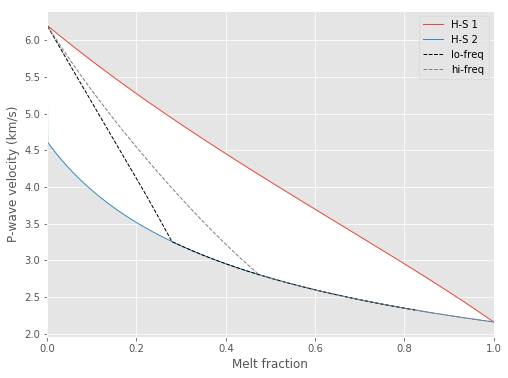

In [10]:
# code 
from elasticc.eep import mod_b, gassman_2
from elasticc.limits import Voigt

# solid
vp_ref = 6.2 # km/s
vpvs = 1.73
vs_ref = vp_ref / vpvs
ro1 = 2.7    # g/cm3
K1 =  K_from_vels(vp_ref, vs_ref, ro1)  # GPa 
G1 =  G_from_vels(vs_ref, ro1)          # GPa 
a1 = 1
# fluid
ro2 = 2.65    # g/cm3
K2 = 12.35    # GPa
G2 = 1e-12    # GPa (numerical zero)
a2 = 0.1
# H-S bounds
c1, c2, K_hs, G_hs = calc_bounds(ro1, K1, G1, ro2, K2, G2)
roe = Voigt(ro1,c1,ro2,c2)
vp_hs1 = vp_KG(K_hs['hs1'], G_hs['hs1'], roe)
vp_hs2 = vp_KG(K_hs['hs2'], G_hs['hs2'], roe)
# Unrelaxed, high frequency limit
K_hi, G_hi = mod_b(K1,K2,G1,G2,a1,a2,c1,c2) # NOTE
vp_hi = vp_KG(K_hi, G_hi, roe)

# Relaxed, low frequency limit
# Calculate dry moduli first (void fill)
K_dry, G_dry = mod_b(K1,0.0,G1,0.0,a1,a2,c1,c2)

# # Then use Gassman's fluid substitution
K_lo, G_lo = gassman_2(K_dry,G_dry,K1,G1,K2,G2,c2) # NOTE
vp_lo = vp_KG(K_lo, G_lo, roe)

figure(8,)
a, b = vp_hs1, vp_hs2
plt.plot(c2, a, label='H-S 1')
plt.plot(c2, b, label='H-S 2')
plt.fill_between(c2, a, b, color='w')
    
plt.plot(c2, vp_lo, 'k--', label='lo-freq')
plt.plot(c2, vp_hi, '--', color='Grey', label='hi-freq')
plt.xlabel('Melt fraction')
plt.ylabel('P-wave velocity (km/s)')
plt.xlim(0,1)
#         plt.ylim(0,100)
plt.grid()
_ = plt.legend()   

# Sensitivity analysis
Move to the other nb.

## Low-frequency limit
Appropriate for field experiments and thus relevant here.

#### Fig.
Dependence on fluid bulk modulus.

CPU times: user 3.83 s, sys: 0 ns, total: 3.83 s
Wall time: 3.83 s


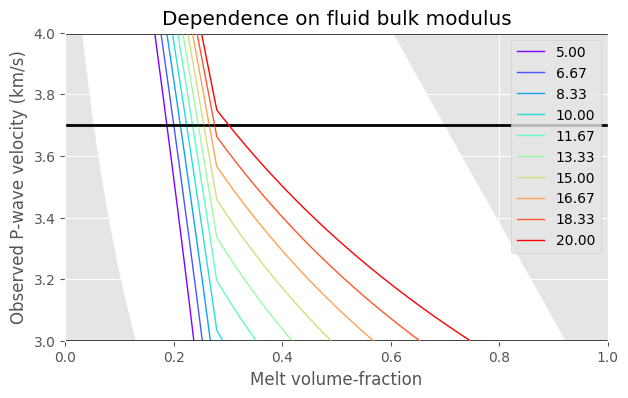

In [24]:
%%time 
title = 'Dependence on fluid bulk modulus'

from elasticc.eep import mod_b, gassman_2
from elasticc.limits import Voigt
from fullwavepy.plot.plt1d import colors

figure(7,4)

vals = np.linspace(5, 20, 10)
cols = colors(len(vals), cmap='rainbow')
for K2 in vals:
    par2label = K2
    # solid
    vp_ref = 6.2 # km/s
    vpvs = 1.73
    vs_ref = vp_ref / vpvs
    ro1 = 2.7    # g/cm3
    K1 =  K_from_vels(vp_ref, vs_ref, ro1)  # GPa 
    G1 =  G_from_vels(vs_ref, ro1)          # GPa 
    a1 = 1
    # fluid
    ro2 = 2.65    # g/cm3
#     K2 = 12.35    # GPa
    G2 = 1e-12    # GPa (numerical zero)
    a2 = 0.1
    # H-S bounds
    c1, c2, K_hs, G_hs = calc_bounds(ro1, K1, G1, ro2, K2, G2)
    roe = Voigt(ro1,c1,ro2,c2)
    vp_hs1 = vp_KG(K_hs['hs1'], G_hs['hs1'], roe)
    vp_hs2 = vp_KG(K_hs['hs2'], G_hs['hs2'], roe)

    
    a, b = vp_hs1, vp_hs2
    # plt.plot(c2, a, label='H-S 1')
    # plt.plot(c2, b, label='H-S 2')
    plt.fill_between(c2, a, b, color='w')

    plt.plot(c2, np.ones(len(c2))*3.0, c='k')
    plt.plot(c2, np.ones(len(c2))*3.7, c='k')
    plt.plot(c2, np.ones(len(c2))*4.0, c='k')




    # step = 0.2

    # Relaxed, low frequency limit
    # Calculate dry moduli first (void fill)
    K_dry, G_dry = mod_b(K1,0.0,G1,0.0,a1,a2,c1,c2)

    # Then use Gassman's fluid substitution
    K_lo, G_lo = gassman_2(K_dry,G_dry,K1,G1,K2,G2,c2) # NOTE
    vp_lo = vp_KG(K_lo, G_lo, roe)

    plt.plot(c2, vp_lo, color=next(cols), label='%.2f' % par2label)
    
plt.xlabel('Melt volume-fraction')
plt.ylabel('Observed P-wave velocity (km/s)')
plt.xlim(0,1)
plt.ylim(3,4)
plt.grid()
plt.title(title)   
_ = plt.legend() 

#### Fig.
Dependence on fluid aspect ratio

CPU times: user 11.8 s, sys: 0 ns, total: 11.8 s
Wall time: 11.8 s


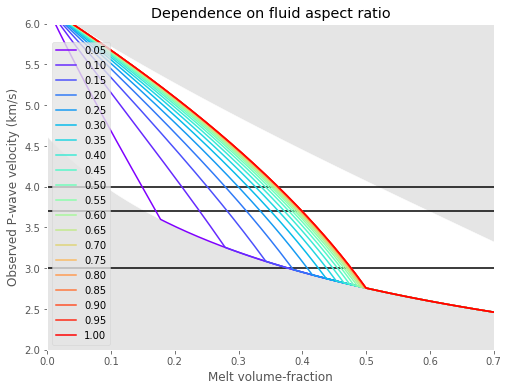

In [86]:
%%time 
title = 'Dependence on fluid aspect ratio'
from elasticc.eep import mod_b, gassman_2
from elasticc.limits import Voigt
from fullwavepy.plot.plt1d import colors


# solid
vp_ref = 6.2 # km/s
vpvs = 1.73
vs_ref = vp_ref / vpvs
ro1 = 2.7    # g/cm3
K1 =  K_from_vels(vp_ref, vs_ref, ro1)  # GPa 
G1 =  G_from_vels(vs_ref, ro1)          # GPa 
a1 = 1
# fluid
ro2 = 2.65    # g/cm3
K2 = 12.35    # GPa
G2 = 1e-12    # GPa (numerical zero)
# a2 = 0.1
# H-S bounds
c1, c2, K_hs, G_hs = calc_bounds(ro1, K1, G1, ro2, K2, G2)
roe = Voigt(ro1,c1,ro2,c2)
vp_hs1 = vp_KG(K_hs['hs1'], G_hs['hs1'], roe)
vp_hs2 = vp_KG(K_hs['hs2'], G_hs['hs2'], roe)

figure(8,)
a, b = vp_hs1, vp_hs2
# plt.plot(c2, a, label='H-S 1')
# plt.plot(c2, b, label='H-S 2')
plt.fill_between(c2, a, b, color='w')

plt.plot(c2, np.ones(len(c2))*3.0, c='k')
plt.plot(c2, np.ones(len(c2))*3.7, c='k')
plt.plot(c2, np.ones(len(c2))*4.0, c='k')

plt.xlabel('Melt volume-fraction')
plt.ylabel('Observed P-wave velocity (km/s)')
plt.xlim(0,.7)
plt.ylim(2,6)
plt.grid()
 

step = 0.05
vals = np.arange(0.05, 1+step, step)
cols = colors(len(vals), cmap='rainbow')
for a2 in vals:
    # Relaxed, low frequency limit
    # Calculate dry moduli first (void fill)
    K_dry, G_dry = mod_b(K1,0.0,G1,0.0,a1,a2,c1,c2)

    # Then use Gassman's fluid substitution
    K_lo, G_lo = gassman_2(K_dry,G_dry,K1,G1,K2,G2,c2) # NOTE
    vp_lo = vp_KG(K_lo, G_lo, roe)
    
    plt.plot(c2, vp_lo, color=next(cols), label='%.2f' % a2)
plt.title(title)   
_ = plt.legend() 
# plt.savefig(path_fig + '/mel_fluid_aspect_ratio.png')

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars


CPU times: user 12 s, sys: 220 ms, total: 12.3 s
Wall time: 11.9 s


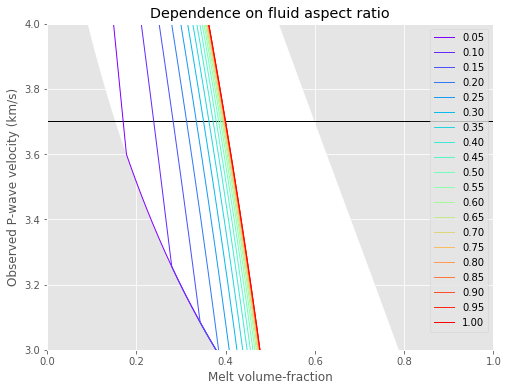

In [13]:
%%time 
title = 'Dependence on fluid aspect ratio'
from elasticc.eep import mod_b, gassman_2
from elasticc.limits import Voigt
from fullwavepy.plot.plt1d import colors


# solid
vp_ref = 6.2 # km/s
vpvs = 1.73
vs_ref = vp_ref / vpvs
ro1 = 2.7    # g/cm3
K1 =  K_from_vels(vp_ref, vs_ref, ro1)  # GPa 
G1 =  G_from_vels(vs_ref, ro1)          # GPa 
a1 = 1
# fluid
ro2 = 2.65    # g/cm3
K2 = 12.35    # GPa
G2 = 1e-12    # GPa (numerical zero)
# a2 = 0.1
# H-S bounds
c1, c2, K_hs, G_hs = calc_bounds(ro1, K1, G1, ro2, K2, G2)
roe = Voigt(ro1,c1,ro2,c2)
vp_hs1 = vp_KG(K_hs['hs1'], G_hs['hs1'], roe)
vp_hs2 = vp_KG(K_hs['hs2'], G_hs['hs2'], roe)

figure(8,)
a, b = vp_hs1, vp_hs2
# plt.plot(c2, a, label='H-S 1')
# plt.plot(c2, b, label='H-S 2')
plt.fill_between(c2, a, b, color='w')

plt.plot(c2, np.ones(len(c2))*3.0, c='k')
plt.plot(c2, np.ones(len(c2))*3.7, c='k')
plt.plot(c2, np.ones(len(c2))*4.0, c='k')

plt.xlabel('Melt volume-fraction')
plt.ylabel('Observed P-wave velocity (km/s)')
plt.xlim(0,1)
plt.ylim(3,4)
plt.grid()
 

step = 0.05
vals = np.arange(0.05, 1+step, step)
cols = colors(len(vals), cmap='rainbow')
for a2 in vals:
    # Relaxed, low frequency limit
    # Calculate dry moduli first (void fill)
    K_dry, G_dry = mod_b(K1,0.0,G1,0.0,a1,a2,c1,c2)

    # Then use Gassman's fluid substitution
    K_lo, G_lo = gassman_2(K_dry,G_dry,K1,G1,K2,G2,c2) # NOTE
    vp_lo = vp_KG(K_lo, G_lo, roe)
    
    plt.plot(c2, vp_lo, color=next(cols), label='%.2f' % a2)
plt.title(title)   
_ = plt.legend() 
plt.savefig(path_fig + '/mel_fluid_aspect_ratio.png')

#### Fig.
Dependence on solid aspect ratio

CPU times: user 6.7 s, sys: 0 ns, total: 6.7 s
Wall time: 6.7 s


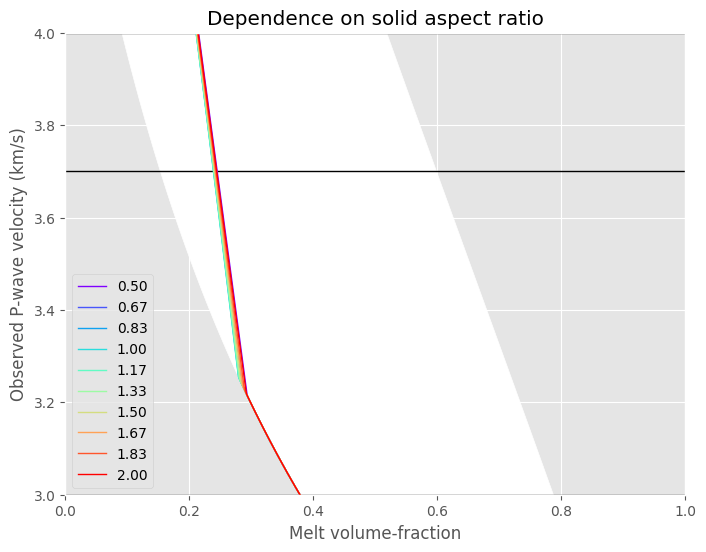

In [14]:
%%time 
title = 'Dependence on solid aspect ratio'
from elasticc.eep import mod_b, gassman_2
from elasticc.limits import Voigt
from fullwavepy.plot.plt1d import colors

# solid
vp_ref = 6.2 # km/s
vpvs = 1.73
vs_ref = vp_ref / vpvs
ro1 = 2.7    # g/cm3
K1 =  K_from_vels(vp_ref, vs_ref, ro1)  # GPa 
G1 =  G_from_vels(vs_ref, ro1)          # GPa 
# a1 = 1
# fluid
ro2 = 2.65    # g/cm3
K2 = 12.35    # GPa
G2 = 1e-12    # GPa (numerical zero)
a2 = 0.1
# H-S bounds
c1, c2, K_hs, G_hs = calc_bounds(ro1, K1, G1, ro2, K2, G2)
roe = Voigt(ro1,c1,ro2,c2)
vp_hs1 = vp_KG(K_hs['hs1'], G_hs['hs1'], roe)
vp_hs2 = vp_KG(K_hs['hs2'], G_hs['hs2'], roe)

figure(8,)
a, b = vp_hs1, vp_hs2
# plt.plot(c2, a, label='H-S 1')
# plt.plot(c2, b, label='H-S 2')
plt.fill_between(c2, a, b, color='w')

plt.plot(c2, np.ones(len(c2))*3.0, c='k')
plt.plot(c2, np.ones(len(c2))*3.7, c='k')
plt.plot(c2, np.ones(len(c2))*4.0, c='k')

plt.xlabel('Melt volume-fraction')
plt.ylabel('Observed P-wave velocity (km/s)')
plt.xlim(0,1)
plt.ylim(3,4)
plt.grid()
 

# step = 0.2
vals = np.linspace(0.5, 2, 10)
cols = colors(len(vals), cmap='rainbow')
for a1 in vals:
    # Relaxed, low frequency limit
    # Calculate dry moduli first (void fill)
    K_dry, G_dry = mod_b(K1,0.0,G1,0.0,a1,a2,c1,c2)

    # Then use Gassman's fluid substitution
    K_lo, G_lo = gassman_2(K_dry,G_dry,K1,G1,K2,G2,c2) # NOTE
    vp_lo = vp_KG(K_lo, G_lo, roe)
    
    plt.plot(c2, vp_lo, color=next(cols), label='%.2f' % a1)
plt.title(title)   
_ = plt.legend() 

#### Fig.
Dependence on reference (solid-matrix) velocity. This is roughly independent of vp, which makes sense.

CPU times: user 3.84 s, sys: 0 ns, total: 3.84 s
Wall time: 3.84 s


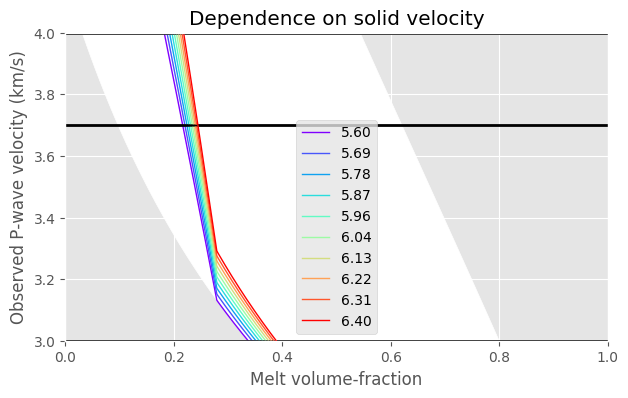

In [25]:
%%time 
title = 'Dependence on solid velocity'

from elasticc.eep import mod_b, gassman_2
from elasticc.limits import Voigt
from fullwavepy.plot.plt1d import colors

figure(7,4)

vals = np.linspace(5.6, 6.4, 10)
cols = colors(len(vals), cmap='rainbow')
for vp_ref in vals:
    par2label = vp_ref
    # solid
    # vp_ref = 6.2 # km/s
    vpvs = 1.73
    vs_ref = vp_ref / vpvs
    ro1 = 2.7    # g/cm3
    K1 =  K_from_vels(vp_ref, vs_ref, ro1)  # GPa 
    G1 =  G_from_vels(vs_ref, ro1)          # GPa 
    a1 = 1
    # fluid
    ro2 = 2.65    # g/cm3
    K2 = 12.35    # GPa
    G2 = 1e-12    # GPa (numerical zero)
    a2 = 0.1
    # H-S bounds
    c1, c2, K_hs, G_hs = calc_bounds(ro1, K1, G1, ro2, K2, G2)
    roe = Voigt(ro1,c1,ro2,c2)
    vp_hs1 = vp_KG(K_hs['hs1'], G_hs['hs1'], roe)
    vp_hs2 = vp_KG(K_hs['hs2'], G_hs['hs2'], roe)

    
    a, b = vp_hs1, vp_hs2
    # plt.plot(c2, a, label='H-S 1')
    # plt.plot(c2, b, label='H-S 2')
    plt.fill_between(c2, a, b, color='w')

    plt.plot(c2, np.ones(len(c2))*3.0, c='k')
    plt.plot(c2, np.ones(len(c2))*3.7, c='k')
    plt.plot(c2, np.ones(len(c2))*4.0, c='k')




    # step = 0.2

    # Relaxed, low frequency limit
    # Calculate dry moduli first (void fill)
    K_dry, G_dry = mod_b(K1,0.0,G1,0.0,a1,a2,c1,c2)

    # Then use Gassman's fluid substitution
    K_lo, G_lo = gassman_2(K_dry,G_dry,K1,G1,K2,G2,c2) # NOTE
    vp_lo = vp_KG(K_lo, G_lo, roe)

    plt.plot(c2, vp_lo, color=next(cols), label='%.2f' % par2label)
    
plt.xlabel('Melt volume-fraction')
plt.ylabel('Observed P-wave velocity (km/s)')
plt.xlim(0,1)
plt.ylim(3,4)
plt.grid()
plt.title(title)   
_ = plt.legend() 

#### Fig.
Dependence on vp/vs

CPU times: user 3.85 s, sys: 0 ns, total: 3.85 s
Wall time: 3.85 s


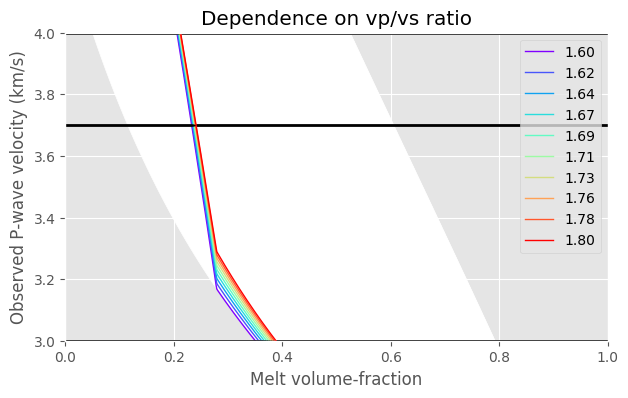

In [28]:
%%time 
title = 'Dependence on vp/vs ratio'

from elasticc.eep import mod_b, gassman_2
from elasticc.limits import Voigt
from fullwavepy.plot.plt1d import colors

figure(7,4)

vals = np.linspace(1.6, 1.8, 10)
cols = colors(len(vals), cmap='rainbow')
for vpvs in vals:
    par2label = vpvs
    # solid
    vp_ref = 6.2 # km/s
#     vpvs = 1.73
    vs_ref = vp_ref / vpvs
    ro1 = 2.7    # g/cm3
    K1 =  K_from_vels(vp_ref, vs_ref, ro1)  # GPa 
    G1 =  G_from_vels(vs_ref, ro1)          # GPa 
    a1 = 1
    # fluid
    ro2 = 2.65    # g/cm3
    K2 = 12.35    # GPa
    G2 = 1e-12    # GPa (numerical zero)
    a2 = 0.1
    # H-S bounds
    c1, c2, K_hs, G_hs = calc_bounds(ro1, K1, G1, ro2, K2, G2)
    roe = Voigt(ro1,c1,ro2,c2)
    vp_hs1 = vp_KG(K_hs['hs1'], G_hs['hs1'], roe)
    vp_hs2 = vp_KG(K_hs['hs2'], G_hs['hs2'], roe)

    
    a, b = vp_hs1, vp_hs2
    # plt.plot(c2, a, label='H-S 1')
    # plt.plot(c2, b, label='H-S 2')
    plt.fill_between(c2, a, b, color='w')

    plt.plot(c2, np.ones(len(c2))*3.0, c='k')
    plt.plot(c2, np.ones(len(c2))*3.7, c='k')
    plt.plot(c2, np.ones(len(c2))*4.0, c='k')




    # step = 0.2

    # Relaxed, low frequency limit
    # Calculate dry moduli first (void fill)
    K_dry, G_dry = mod_b(K1,0.0,G1,0.0,a1,a2,c1,c2)

    # Then use Gassman's fluid substitution
    K_lo, G_lo = gassman_2(K_dry,G_dry,K1,G1,K2,G2,c2) # NOTE
    vp_lo = vp_KG(K_lo, G_lo, roe)

    plt.plot(c2, vp_lo, color=next(cols), label='%.2f' % par2label)
    
plt.xlabel('Melt volume-fraction')
plt.ylabel('Observed P-wave velocity (km/s)')
plt.xlim(0,1)
plt.ylim(3,4)
plt.grid()
plt.title(title)   
_ = plt.legend() 

#### Fig.
Dependence on fluid density. This is quite unintuitive.

CPU times: user 3.84 s, sys: 0 ns, total: 3.84 s
Wall time: 3.84 s


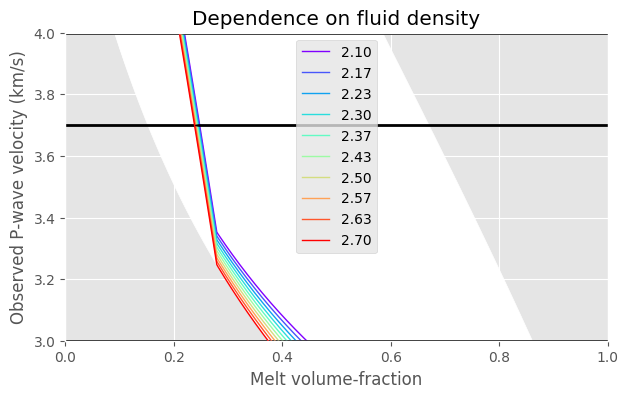

In [27]:
%%time 
title = 'Dependence on fluid density'

from elasticc.eep import mod_b, gassman_2
from elasticc.limits import Voigt
from fullwavepy.plot.plt1d import colors

figure(7,4)

vals = np.linspace(2.1, 2.7, 10)
cols = colors(len(vals), cmap='rainbow')
for ro2 in vals:
    par2label = ro2
    # solid
    vp_ref = 6.2 # km/s
    vpvs = 1.73
    vs_ref = vp_ref / vpvs
    ro1 = 2.7    # g/cm3
    K1 =  K_from_vels(vp_ref, vs_ref, ro1)  # GPa 
    G1 =  G_from_vels(vs_ref, ro1)          # GPa 
    a1 = 1
    # fluid
#     ro2 = 2.65    # g/cm3
    K2 = 12.35    # GPa
    G2 = 1e-12    # GPa (numerical zero)
    a2 = 0.1
    # H-S bounds
    c1, c2, K_hs, G_hs = calc_bounds(ro1, K1, G1, ro2, K2, G2)
    roe = Voigt(ro1,c1,ro2,c2)
    vp_hs1 = vp_KG(K_hs['hs1'], G_hs['hs1'], roe)
    vp_hs2 = vp_KG(K_hs['hs2'], G_hs['hs2'], roe)

    
    a, b = vp_hs1, vp_hs2
    # plt.plot(c2, a, label='H-S 1')
    # plt.plot(c2, b, label='H-S 2')
    plt.fill_between(c2, a, b, color='w')

    plt.plot(c2, np.ones(len(c2))*3.0, c='k')
    plt.plot(c2, np.ones(len(c2))*3.7, c='k')
    plt.plot(c2, np.ones(len(c2))*4.0, c='k')




    # step = 0.2

    # Relaxed, low frequency limit
    # Calculate dry moduli first (void fill)
    K_dry, G_dry = mod_b(K1,0.0,G1,0.0,a1,a2,c1,c2)

    # Then use Gassman's fluid substitution
    K_lo, G_lo = gassman_2(K_dry,G_dry,K1,G1,K2,G2,c2) # NOTE
    vp_lo = vp_KG(K_lo, G_lo, roe)

    plt.plot(c2, vp_lo, color=next(cols), label='%.2f' % par2label)
    
plt.xlabel('Melt volume-fraction')
plt.ylabel('Observed P-wave velocity (km/s)')
plt.xlim(0,1)
plt.ylim(3,4)
plt.grid()
plt.title(title)   
_ = plt.legend() 

## High-frequency limit
Appropriate for lab experiments. Not relevant, but still carried out for comparison. Same as above but variability of H-S bounds also shown.

#### Fig.
Dependence on solid aspect ratio

CPU times: user 6.28 s, sys: 0 ns, total: 6.28 s
Wall time: 6.28 s


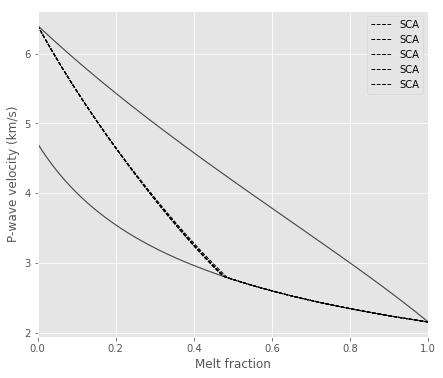

In [52]:
%%time 
ro1 = 2.7    # g/cm3
K1 =  60     # GPa from Montserrat xlsx
G1 =  38     # GPa same

# Melt phase properties (from McVey2020)
# They need to be at the same (p,T) as solid matrix, I guess
ro2 = 2.65    # g/cm3
K2 = 12.35    # GPa
G2 = 1e-12    # GPa (numerical zero)

# a1 = 1    # aspect ratio of solid
a2 = 0.1  # aspect ratio of fluid

figure(7,)
for a1 in np.linspace(0.5,1,5):
    roe = Voigt(ro1,c1,ro2,c2)
    c1, c2, K, G = calc_bounds(ro1, K1, G1, ro2, K2, G2)
    
    
    Ksc, Gsc = mod_b(K1,K2,G1,G2,a1,a2,c1,c2)
    vsc = vp_KG(Ksc, Gsc, roe)    
    for i, (name, func) in enumerate(zip(['P-wave velocity', 'S-wave velocity'], [vp_KG, vs_KG])):
        a = func(K['hs1'], G['hs1'], roe)
        b = func(K['hs2'], G['hs2'], roe)
#         plt.subplot(121+i)
        plt.plot(c2, a, c='k', alpha=.2)
        plt.plot(c2, b, c='k', alpha=.2)
#         plt.fill_between(c2, a, b, color='w')
        if i == 0:
            plt.plot(c2, vsc, 'k--', label='SCA')
        break
plt.xlabel('Melt fraction')
plt.ylabel('%s (km/s)' % name)
plt.xlim(0,1)
#         plt.ylim(0,100)
plt.grid()
_ = plt.legend()     

#### Fig.
Dependence on fluid aspect ratio

CPU times: user 3.36 s, sys: 0 ns, total: 3.36 s
Wall time: 3.36 s


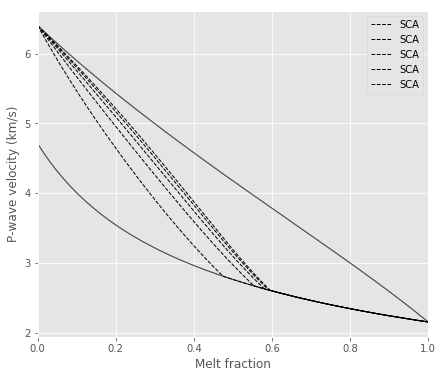

In [51]:
%%time 
ro1 = 2.7    # g/cm3
K1 =  60     # GPa from Montserrat xlsx
G1 =  38     # GPa same

# Melt phase properties (from McVey2020)
# They need to be at the same (p,T) as solid matrix, I guess
ro2 = 2.65    # g/cm3
K2 = 12.35    # GPa
G2 = 1e-12    # GPa (numerical zero)

a1 = 1    # aspect ratio of solid
# a2 = 0.1  # aspect ratio of fluid

figure(7,)
for a2 in np.linspace(.1,0.5,5):
    roe = Voigt(ro1,c1,ro2,c2)
    c1, c2, K, G = calc_bounds(ro1, K1, G1, ro2, K2, G2)
    
    
    Ksc, Gsc = mod_b(K1,K2,G1,G2,a1,a2,c1,c2)
    vsc = vp_KG(Ksc, Gsc, roe)    
    for i, (name, func) in enumerate(zip(['P-wave velocity', 'S-wave velocity'], [vp_KG, vs_KG])):
        a = func(K['hs1'], G['hs1'], roe)
        b = func(K['hs2'], G['hs2'], roe)
#         plt.subplot(121+i)
        plt.plot(c2, a, c='k', alpha=.2)
        plt.plot(c2, b, c='k', alpha=.2)
#         plt.fill_between(c2, a, b, color='w')
        if i == 0:
            plt.plot(c2, vsc, 'k--', label='SCA')
        break
plt.xlabel('Melt fraction')
plt.ylabel('%s (km/s)' % name)
plt.xlim(0,1)
#         plt.ylim(0,100)
plt.grid()
_ = plt.legend()     

#### Fig.
Dependence on solid bulk modulus.

CPU times: user 2.46 s, sys: 0 ns, total: 2.46 s
Wall time: 2.46 s


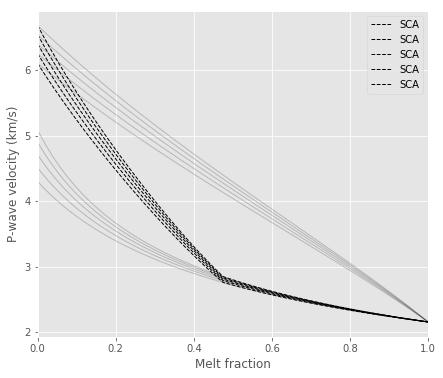

In [45]:
%%time 
ro1 = 2.7    # g/cm3
# K1 =  60     # GPa from Montserrat xlsx
G1 =  38     # GPa same

# Melt phase properties (from McVey2020)
# They need to be at the same (p,T) as solid matrix, I guess
ro2 = 2.65    # g/cm3
K2 = 12.35    # GPa
G2 = 1e-12    # GPa (numerical zero)
roe = Voigt(ro1,c1,ro2,c2)
figure(7,)
for K1 in np.linspace(50,70,5):
    c1, c2, K, G = calc_bounds(ro1, K1, G1, ro2, K2, G2)
    a1 = 1    # aspect ratio of solid
    a2 = 0.1  # aspect ratio of fluid
    Ksc, Gsc = mod_b(K1,K2,G1,G2,a1,a2,c1,c2)
    vsc = vp_KG(Ksc, Gsc, roe)    
    for i, (name, func) in enumerate(zip(['P-wave velocity', 'S-wave velocity'], [vp_KG, vs_KG])):
        a = func(K['hs1'], G['hs1'], roe)
        b = func(K['hs2'], G['hs2'], roe)
#         plt.subplot(121+i)
        plt.plot(c2, a, c='k', alpha=.2)
        plt.plot(c2, b, c='k', alpha=.2)
#         plt.fill_between(c2, a, b, color='w')
        if i == 0:
            plt.plot(c2, vsc, 'k--', label='SCA')
        break
plt.xlabel('Melt fraction')
plt.ylabel('%s (km/s)' % name)
plt.xlim(0,1)
#         plt.ylim(0,100)
plt.grid()
_ = plt.legend()     

#### Fig.
Dependence on fluid bulk modulus.

CPU times: user 2.56 s, sys: 4 ms, total: 2.57 s
Wall time: 2.57 s


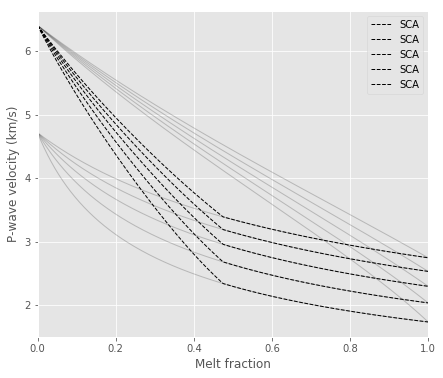

In [46]:
%%time 
ro1 = 2.7    # g/cm3
K1 =  60     # GPa from Montserrat xlsx
G1 =  38     # GPa same

# Melt phase properties (from McVey2020)
# They need to be at the same (p,T) as solid matrix, I guess
ro2 = 2.65    # g/cm3
# K2 = 12.35    # GPa
G2 = 1e-12    # GPa (numerical zero)
roe = Voigt(ro1,c1,ro2,c2)
figure(7,)
for K2 in np.linspace(8,20,5):
    c1, c2, K, G = calc_bounds(ro1, K1, G1, ro2, K2, G2)
    a1 = 1    # aspect ratio of solid
    a2 = 0.1  # aspect ratio of fluid
    Ksc, Gsc = mod_b(K1,K2,G1,G2,a1,a2,c1,c2)
    vsc = vp_KG(Ksc, Gsc, roe)    
    for i, (name, func) in enumerate(zip(['P-wave velocity', 'S-wave velocity'], [vp_KG, vs_KG])):
        a = func(K['hs1'], G['hs1'], roe)
        b = func(K['hs2'], G['hs2'], roe)
#         plt.subplot(121+i)
        plt.plot(c2, a, c='k', alpha=.2)
        plt.plot(c2, b, c='k', alpha=.2)
#         plt.fill_between(c2, a, b, color='w')
        if i == 0:
            plt.plot(c2, vsc, 'k--', label='SCA')
        break
plt.xlabel('Melt fraction')
plt.ylabel('%s (km/s)' % name)
plt.xlim(0,1)
#         plt.ylim(0,100)
plt.grid()
_ = plt.legend()     

#### Fig.
Dependence on solid shear modulus. (Fluid shear modulus is zero always)

CPU times: user 2.37 s, sys: 0 ns, total: 2.37 s
Wall time: 2.36 s


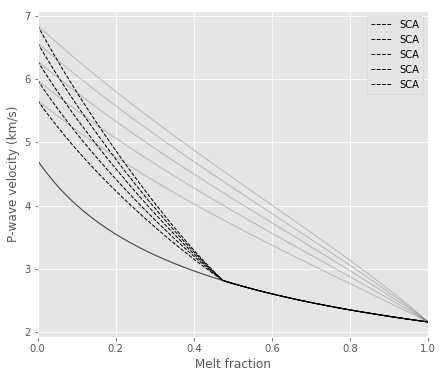

In [47]:
%%time 
ro1 = 2.7    # g/cm3
K1 =  60     # GPa from Montserrat xlsx
# G1 =  38     # GPa same

# Melt phase properties (from McVey2020)
# They need to be at the same (p,T) as solid matrix, I guess
ro2 = 2.65    # g/cm3
K2 = 12.35    # GPa
G2 = 1e-12    # GPa (numerical zero)
roe = Voigt(ro1,c1,ro2,c2)
figure(7,)
for G1 in np.linspace(20,50,5):
    c1, c2, K, G = calc_bounds(ro1, K1, G1, ro2, K2, G2)
    a1 = 1    # aspect ratio of solid
    a2 = 0.1  # aspect ratio of fluid
    Ksc, Gsc = mod_b(K1,K2,G1,G2,a1,a2,c1,c2)
    vsc = vp_KG(Ksc, Gsc, roe)    
    for i, (name, func) in enumerate(zip(['P-wave velocity', 'S-wave velocity'], [vp_KG, vs_KG])):
        a = func(K['hs1'], G['hs1'], roe)
        b = func(K['hs2'], G['hs2'], roe)
#         plt.subplot(121+i)
        plt.plot(c2, a, c='k', alpha=.2)
        plt.plot(c2, b, c='k', alpha=.2)
#         plt.fill_between(c2, a, b, color='w')
        if i == 0:
            plt.plot(c2, vsc, 'k--', label='SCA')
        break
plt.xlabel('Melt fraction')
plt.ylabel('%s (km/s)' % name)
plt.xlim(0,1)
#         plt.ylim(0,100)
plt.grid()
_ = plt.legend()     

#### Fig.
Dependence on solid density

CPU times: user 2.48 s, sys: 0 ns, total: 2.48 s
Wall time: 2.47 s


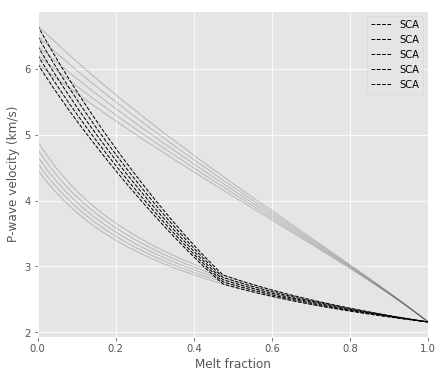

In [49]:
%%time 
# ro1 = 2.7    # g/cm3
K1 =  60     # GPa from Montserrat xlsx
G1 =  38     # GPa same

# Melt phase properties (from McVey2020)
# They need to be at the same (p,T) as solid matrix, I guess
ro2 = 2.65    # g/cm3
K2 = 12.35    # GPa
G2 = 1e-12    # GPa (numerical zero)

figure(7,)
for ro1 in np.linspace(2.5,3.0,5):
    roe = Voigt(ro1,c1,ro2,c2)
    c1, c2, K, G = calc_bounds(ro1, K1, G1, ro2, K2, G2)
    a1 = 1    # aspect ratio of solid
    a2 = 0.1  # aspect ratio of fluid
    Ksc, Gsc = mod_b(K1,K2,G1,G2,a1,a2,c1,c2)
    vsc = vp_KG(Ksc, Gsc, roe)    
    for i, (name, func) in enumerate(zip(['P-wave velocity', 'S-wave velocity'], [vp_KG, vs_KG])):
        a = func(K['hs1'], G['hs1'], roe)
        b = func(K['hs2'], G['hs2'], roe)
#         plt.subplot(121+i)
        plt.plot(c2, a, c='k', alpha=.2)
        plt.plot(c2, b, c='k', alpha=.2)
#         plt.fill_between(c2, a, b, color='w')
        if i == 0:
            plt.plot(c2, vsc, 'k--', label='SCA')
        break
plt.xlabel('Melt fraction')
plt.ylabel('%s (km/s)' % name)
plt.xlim(0,1)
#         plt.ylim(0,100)
plt.grid()
_ = plt.legend()     

#### Fig.
Dependence on fluid density

CPU times: user 2.5 s, sys: 4 ms, total: 2.51 s
Wall time: 2.5 s


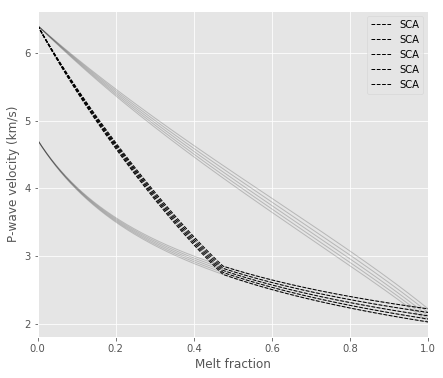

In [50]:
%%time 
ro1 = 2.7    # g/cm3
K1 =  60     # GPa from Montserrat xlsx
G1 =  38     # GPa same

# Melt phase properties (from McVey2020)
# They need to be at the same (p,T) as solid matrix, I guess
# ro2 = 2.65    # g/cm3
K2 = 12.35    # GPa
G2 = 1e-12    # GPa (numerical zero)

figure(7,)
for ro2 in np.linspace(2.5,3.0,5):
    roe = Voigt(ro1,c1,ro2,c2)
    c1, c2, K, G = calc_bounds(ro1, K1, G1, ro2, K2, G2)
    a1 = 1    # aspect ratio of solid
    a2 = 0.1  # aspect ratio of fluid
    Ksc, Gsc = mod_b(K1,K2,G1,G2,a1,a2,c1,c2)
    vsc = vp_KG(Ksc, Gsc, roe)    
    for i, (name, func) in enumerate(zip(['P-wave velocity', 'S-wave velocity'], [vp_KG, vs_KG])):
        a = func(K['hs1'], G['hs1'], roe)
        b = func(K['hs2'], G['hs2'], roe)
#         plt.subplot(121+i)
        plt.plot(c2, a, c='k', alpha=.2)
        plt.plot(c2, b, c='k', alpha=.2)
#         plt.fill_between(c2, a, b, color='w')
        if i == 0:
            plt.plot(c2, vsc, 'k--', label='SCA')
        break
plt.xlabel('Melt fraction')
plt.ylabel('%s (km/s)' % name)
plt.xlim(0,1)
#         plt.ylim(0,100)
plt.grid()
_ = plt.legend()     

# Appendix

## Differential effective medium
Also using Gassman's fluid substitution

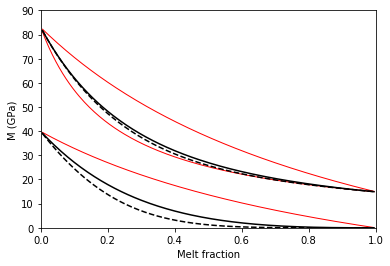

In [8]:
# Aspect ratio of two phases
a2=0.1
# Unrelaxed, high frequency limit
a_Ku1,a_Gu1 = el.eep.dem(K1,K2,G1,G2,a2,c2)
a_Vpu1=np.sqrt((a_Ku1+4.0/3.0*a_Gu1)/roe)
a_Vsu1=np.sqrt(a_Gu1/roe)
# Relaxed, low frequency limit
# Calculate dry moduli first (void fill)
K,G = el.eep.dem(K1,0.0,G1,0.0,a2,c2)
# Then use Gassman's fluid substitution
a_Kr1,a_Gr1 = el.eep.gassman_2(K,G,K1,G1,K2,G2,c2)
a_Vpr1=np.sqrt((a_Kr1+4.0/3.0*a_Gr1)/roe)
a_Vsr1=np.sqrt(a_Gr1/roe)

pmin=0
pmax=1
fig = plt.figure()
plt.xlabel('Melt fraction')
plt.ylabel('M (GPa)')
plt.xlim(pmin,pmax)
plt.ylim(0,90)
plt.plot(c2,Khs1,lw='1',c='r')
plt.plot(c2,Khs2,lw='1',c='r')
plt.plot(c2,Ghs1,lw='1',c='r')
plt.plot(c2,Ghs2,lw='1',c='r')
plt.plot(c2,a_Ku1,c='black',linewidth=1.5)
plt.plot(c2,a_Kr1,c='black',linestyle='--',linewidth=1.5)
plt.plot(c2,a_Gu1,c='black',linewidth=1.5)
plt.plot(c2,a_Gr1,c='black',linestyle='--',linewidth=1.5)
plt.show()

## Markov-chain Monte Carlo

In [3]:
def gauss(x, mu=0, sigma=1):
    return np.exp(-(x - mu)**2/(2*sigma**2))

def forward(x):
    return gauss(x, mu=500, sigma=500)

def misfit(dsyn, dobs):
    return np.sqrt((dsyn - dobs)**2)

def likelihood(dsyn, dobs):
    misf = misfit(dsyn, dobs)
    #print('deltad', deltad)
    return (1/np.sqrt(2 * np.pi)) * np.exp(-(misf**2)/2)

def perturb(x):
    sigma = 1000 # THIS IS TO BE TUNED!!!
    xprim = np.clip(np.random.normal(x, sigma), xmin, xmax) # CLIP TO PRIOR!
    return xprim

def accept_prob(d1, d2, dobs):
    """
    d1, d2 - data vectors
    """
    lhood1 = likelihood(d1, dobs)
    lhood2 = likelihood(d2, dobs)
    ratio = lhood2/lhood1
    #print('ratio', ratio)
    p = min(1, ratio)
    return p

def accept(threshold):
    a = np.random.uniform()
    print(a)
    if a > threshold:
        return True
    else:
        return False

# accept(0.5)

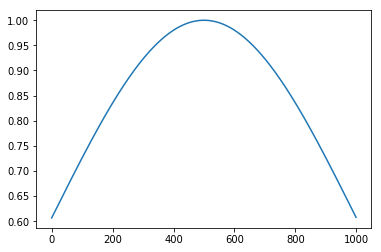

In [3]:
n = 1000
x = np.arange(n)
y = forward(x)
plt.plot(x, y)

In [4]:
# prior
xmin = 0
xmax = 1000
x0 = np.random.uniform(xmin, xmax, 1)
print(x0)

[466.78358555]


In [6]:
dobs = forward(x)
print(dobs)

[0.99779577]


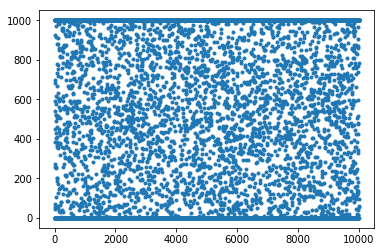

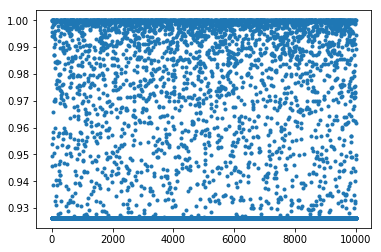

In [7]:
x = x0 # DRAW THE FIRST SAMPLE FROM THE PRIOR
d = forward(x)

xlist = []
plist = []
post = []
for _ in range(10000):
    xprim = perturb(x)
    dprim = forward(xprim)
    accept_p = accept_prob(d, dprim, dobs)

    if accept_p:
        x = xprim
    
    post.append(x)
    plist.append(accept_p)
    xlist.append(xprim)

# plt.plot(xlist, '.')
plt.figure()
plt.plot(post, '.')
plt.figure()
plt.plot(plist, '.')
# print(plist)

# ...